# Program za iskanje karakterizacije za grafe $G$ z neodvisno liho množico velikosti 1

## Navodila za uporabo main.ipynb

### Predpogoji

Za delovanje programa je potrebno imeti nameščen SageMath.

### Navodila za uporabo

1. Odprite datoteko `main.ipynb`

2. Poganjajte celice po vrsti

### Struktura programa

Program je razdeljen v sledeče dele:

1. Definicija funkcij za računanje `alpha_od(G)` in `chi_so(G)`
2. Generiranje grafov z lastnostjo `alpha_od(G) == 1`
3. Shranjevanje najdenih grafov v datoteko `graphs_with_alpha_od_1.g6`
4. Testiranje hipotez o lastnostih grafov in zapis rezultatov v datoteko `test_results.txt`

### Opombe

- Funkcija `generate_all_alpha_od_1_graphs()` potrebuje približno 2 uri.

---

## 1. Definicija funkcij

Najprej bomo prevedli celoštevilski linearni program iz navodil v funkcijo `alpha_od(G)`. Funkcija vrne velikost največje lihe neodvisne množice v grafu $G$.

In [ ]:
def alpha_od(G):
    """
    Compute the size of the maximum odd independent set in the graph G.
    """
    from sage.numerical.mip import MixedIntegerLinearProgram
    
    n = G.order()
    V = G.vertices()
    
    # Create the mixed integer linear program
    mip = MixedIntegerLinearProgram(maximization=True)
    
    # Define variables
    x = mip.new_variable(binary=True) # Indicator if vertex v is in the independent set
    y = mip.new_variable(binary=True) # Indicator if vertex v has neighbors in the independent set
    z = mip.new_variable(integer=True) # Counter for the vertex v
    
    # Objective function
    mip.set_objective(mip.sum(x[v] for v in V))
    
    # Constraints
    for u, v in G.edges(labels=False):
        mip.add_constraint(x[u] + x[v] <= 1)
        
    for u in V:
        sum_neighbors = mip.sum(x[v] for v in G.neighbors(u))
        mip.add_constraint(sum_neighbors <= n * y[u])
        mip.add_constraint(y[u] + sum_neighbors == 2*z[u])
    
    # Solve the MIP
    return int(mip.solve())

Preverimo delovanje `alpha_od(G)` na nekaterih manjših grafih.

In [ ]:
from sage.all import Graph
from sage.graphs.graph_generators import graphs

P4 = graphs.PathGraph(4)
C4 = graphs.CycleGraph(4)
C5 = graphs.CycleGraph(5)

for name, G in [("P4", P4), ("C4", C4), ("C5", C5)]:
    print(name, "alpha_od =", alpha_od(G))

P4 alpha_od = 2
C4 alpha_od = 1
C5 alpha_od = 1


Zapisali bomo tudi CLP za določanje najmanjšega število barv za krepko liho barvanje grafa $G$.

In [ ]:
def chi_so(G):
    """
    Compute the size of the minimum strong odd coloring of the graph G.
    """
    from sage.numerical.mip import MixedIntegerLinearProgram
    
    n = G.order()
    V = G.vertices()
    
    # Create the mixed integer linear program
    mip = MixedIntegerLinearProgram(maximization=False)
    
    # Define variables
    x = mip.new_variable(binary=True) # Indicator if vertex v has color i
    y = mip.new_variable(binary=True) # Indicator if color i is used
    z = mip.new_variable(integer=True) # Counter for vertex v and color i
    w = mip.new_variable(binary=True) # Indicator if color i appears in the neighborhood of vertex v
    
    # Objective function
    mip.set_objective(mip.sum(y[i] for i in range(n))) # n is obvious upper bound on colors
    
    # Constraints
    for v in V:
        mip.add_constraint(mip.sum(x[v, i] for i in range(n)) == 1) # Each vertex gets exactly one color
        
    for u, v in G.edges(labels=False):
        for i in range(n):
            mip.add_constraint(x[u, i] + x[v, i] <= 1) # Adjacent vertices have different colors
            
    for i in range(n):
        mip.add_constraint(mip.sum(x[v, i] for v in V) <= n * y[i]) # If color i is used, y[i] = 1
   
    for v in V:
        for i in range(n):
            sum_neighbors = mip.sum(x[u, i] for u in G.neighbors(v))
            deg = len(G.neighbors(v))
            mip.add_constraint(w[v, i] <= sum_neighbors) # w[v,i] = 0 if color i does not appear in neighborhood of v
            mip.add_constraint(sum_neighbors <= deg * w[v, i]) # w[v,i] = 1 if color i appears in neighborhood of v
            # these two conditions together mean w[v,i] = 1 iff color i appears in neighborhood of v
            mip.add_constraint(w[v, i] + sum_neighbors == 2 * z[v, i]) # Strong odd coloring condition
            mip.add_constraint(z[v, i] >= 0)
    
    # Solve the MIP
    return int(mip.solve())

Prav tako preverimo delovanje `chi_so(G)` na nekaterih majhnih grafih.

In [ ]:
P4 = graphs.PathGraph(4)
C4 = graphs.CycleGraph(4)
C5 = graphs.CycleGraph(5)
K34 = graphs.CompleteBipartiteGraph(3, 4)
for name, G in [("P4", P4), ("C4", C4), ("C5", C5), ("K34", K34)]:
    print(name, "chi_so =", chi_so(G))

P4 chi_so = 3
C4 chi_so = 4
C5 chi_so = 5
K34 chi_so = 3


Potrebovali bomo tudi funkcijo `is_claw_free(G)`, ki za dan graf $G$ preveri, če je claw-free. Graf $G$ je claw-free, če ne vsebuje grafa $K_{1,3}$ kot induciranega podgrafa.

In [ ]:
def is_claw_free(G):
    """
    Check if the given graph G is claw-free. A graph is claw-free if it does not contain K_{1,3} as an induced subgraph.
    """
    from sage.graphs.graph_generators import graphs
    
    claw = graphs.ClawGraph() # K_{1,3}
    return G.subgraph_search(claw, induced=True) is None # subgraph_search returns None if no such subgraph is found

Preverimo delovanje na nekaterih znanih grafih.

In [ ]:
print(is_claw_free(graphs.CycleGraph(10)))
print(is_claw_free(graphs.PathGraph(7)))
print(is_claw_free(graphs.CompleteGraph(6)))
print(is_claw_free(graphs.StarGraph(4)))
print(is_claw_free(graphs.CompleteBipartiteGraph(3,3)))

True
True
True
False
False


## 2. Generiranje grafov z lastnostjo $\alpha_{od}(G) = 1$

Zapisali bomo tudi funkcijo, ki generira vse grafe dane velikosti $n$ z lastnostjo `alpha_od(G)` = 1 in preverili delovanje za $n = 3$. Ker nekatere velike grafe lahko izločimo že iz pogoja $G.\text{diameter()} > 2$, lahko uporabimo to funkcijo tudi za večje $n$, kakor bi sicer, če bi samo računali CLP za vsak graf $G$.

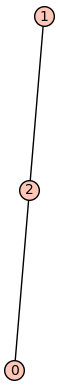

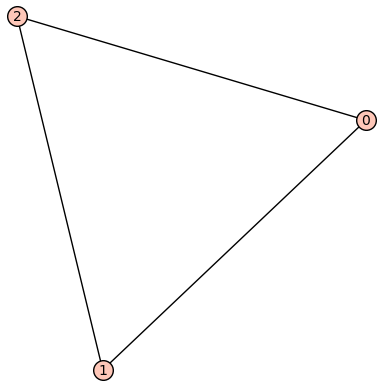

In [ ]:
def generate_graphs_with_alpha_od_equal_to_1(n):
    """
    Iterate over all non-isomorphic graphs with n vertices and return a list of those graphs G for which alpha_od(G) == 1. It is meant to used for n <= 9.
    """
    from sage.graphs.graph_generators import graphs
    
    matches = list()
    for G in graphs(n):
        if G.diameter() > 2:
            continue  # Neccessary condition for alpha_od(G) == 1 is diameter at most 2
        elif alpha_od(G) == 1:
            matches.append(G)
            
    return matches

graphs_with_alpha_od_1 = generate_graphs_with_alpha_od_equal_to_1(3)
for G in graphs_with_alpha_od_1:
    G.show()

Potrebovali bomo funkcijo, ki generira grafe z lastnostjo `alpha_od(G) == 1` za grafe $G = (V, E)$, kjer $|V| \geq 10$. Namreč takih grafov je preveč, da bi lahko preverili za vsakega posebej. Generirali bomo naključen graf, ga popravili, da ima znan potreben pogoj (to je, da je premer $\leq 2$) in šele takrat poračunali `alpha_so(G)`.

In [ ]:
def add_edges_until_diameter_leq_2(G, seed=None):
    """
    Given a graph G, iteratively add edges so that the resulting
    graph H has diameter <= 2.
    
    Process:
    - Compute the diameter path
    - Randomly pick two non-adjacent vertices on that path
    - Add one edge between them
    - Repeat
    
    Returns the modified graph H.
    """
    
    import random
    if seed is not None:
        random.seed(int(seed))

    H = G.copy()
    diameter = H.diameter()

    while diameter > 2:
        # Find one pair of vertices with distance equal to diameter
        vertices = H.vertices()
        
        max_distance_pair = next(
            (
                (vertices[i], vertices[j]) 
                for i in range(len(vertices)) 
                for j in range(i+1, len(vertices)) 
                if H.distance(vertices[i], vertices[j]) == diameter
            ), 
            None
        )

        if max_distance_pair is None: # Safety check
            break

        u, v = max_distance_pair
        # Get the shortest path between u, v
        path = H.shortest_path(u, v)
        
        # Find non-adjacent vertex pairs in the path
        non_adjacent_pairs = [
            (path[i], path[j]) 
            for i in range(len(path)) 
            for j in range(i+2, len(path)) # i+2 ensures non adjacent, since diameter > 2 this exists
            if not H.has_edge(path[i], path[j])
        ]
        
        if non_adjacent_pairs == []: # Safety check
            break

        # Randomly select two vertices to connect
        a, b = random.choice(non_adjacent_pairs)
        H.add_edge(a, b)
        diameter = H.diameter() # update diameter
    return H

Delovanje lahko preverimo na grafu $P_5$.

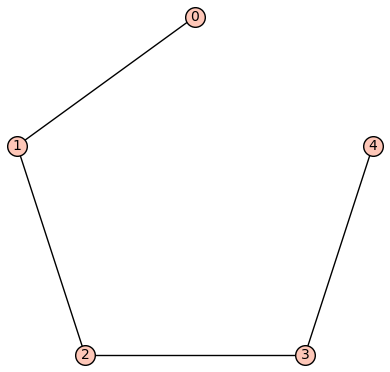

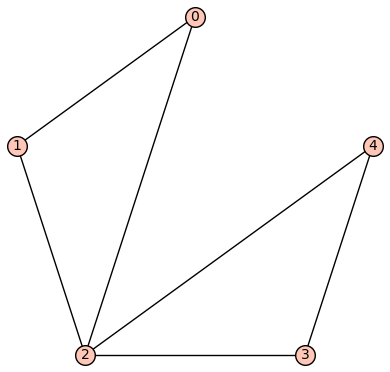

G.diameter() = 4
H.diameter() = 2


In [ ]:
G = graphs.PathGraph(5)
G.show(layout="circular")
H = add_edges_until_diameter_leq_2(G, seed=42)
H.show(layout="circular")

print(f"G.diameter() = {G.diameter()}")
print(f"H.diameter() = {H.diameter()}")

S pomočjo te funkcije bomo lahko iskali tudi po večjih grafih, ki jih bomo najprej primerno popravili, da bodo imeli potreben pogoj.

In [ ]:
def generate_large_graphs_with_alpha_od_equal_to_1(n, attempts, seed=None):
    """
    Generate 'attempts' random graphs with 'n' vertices and diameter <= 2,
    and return those graphs G for which alpha_od(G) == 1.
    """
    import random
    if seed is not None:
        random.seed(int(seed))
    
    matches = list()
    seen_isomorphs = set()
    
    for _ in range(attempts):
        G = graphs.RandomGNP(n, p=0.5, seed=random.randint(0, int(1e6)))
        H = add_edges_until_diameter_leq_2(G, seed=random.randint(0, int(1e6)))
        
        canon_repr = H.canonical_label().graph6_string()
        if canon_repr in seen_isomorphs:
            continue # dont compute alpha_od for already seen graphs
        
        if alpha_od(H) == 1:
            seen_isomorphs.add(canon_repr)
            matches.append(H)
            
    return matches

Preverimo delovanje na naključnem grafu velikosti 30.

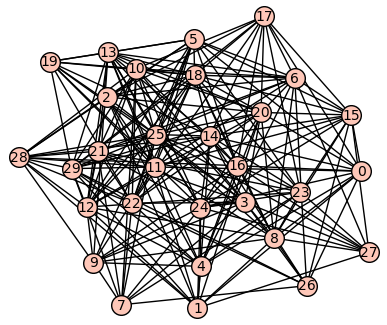

In [ ]:
for G in generate_large_graphs_with_alpha_od_equal_to_1(n=30, attempts=1, seed=42):
    G.show()

Dodali bomo tudi funkcijo, ki za večje grafe namesto naključnega generiranja grafov in popravljanja vsako iteracijo naključno generira le prvi graf, nato pa s spreminjanjem dobimo naslednji graf.

In [ ]:
def generate_large_graphs_with_alpha_od_equal_to_1_dependent(n, attempts, perturbation_attempts, seed=None):
    """
    Generate 'attempts' random graphs with 'n' vertices and diameter <= 2,
    and return those graphs G for which alpha_od(G) == 1.
    Each graph in the iterations is dependent on the previous one by randomly performing edge swaps.
    """
    import random
    from sage.graphs.graph_generators import graphs

    if seed is not None:
        random.seed(int(seed))

    matches = list()
    seen_isomorphs = set()

    G = graphs.RandomGNP(n, p=0.7, seed=random.randint(0, int(1e6)))
    G = add_edges_until_diameter_leq_2(G, seed=random.randint(0, int(1e6)))

    for _ in range(attempts):
        if alpha_od(G) == 1:
            canon_repr = G.canonical_label().graph6_string()
            if canon_repr not in seen_isomorphs:
                seen_isomorphs.add(canon_repr)
                matches.append(G.copy())

        edges = G.edges(labels=False)
        for _ in range(perturbation_attempts):
            if len(edges) < 2:
                break
            
            e1_idx = random.randint(0, len(edges)-1)
            e2_idx = random.randint(0, len(edges)-1)

            if e1_idx == e2_idx:
                continue
            
            u, v = edges[e1_idx]
            x, y = edges[e2_idx]

            distinct_vertices = {u, v, x, y}
            if len(distinct_vertices) < 4:
                continue

            # Randomly decide swap direction
            if random.random() < 0.5:
                G.delete_edge(u, v)
                G.delete_edge(x, y)
                G.add_edge(u, x)
                G.add_edge(v, y)
            else:
                G.delete_edge(u, v)
                G.delete_edge(x, y)
                G.add_edge(u, y)
                G.add_edge(v, x)
            break
        G = add_edges_until_diameter_leq_2(G, seed=random.randint(0, int(1e6))) 
    
    print(f"Found {len(matches)} unique graphs with alpha_od = 1 for n = {n}.")
    return matches

Preverimo delovanje še te funkcije.

Found 2 unique graphs with alpha_od = 1 for n = 10.


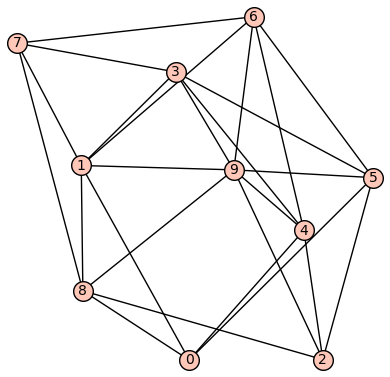

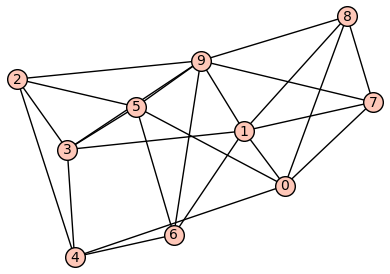

In [ ]:
for G in generate_large_graphs_with_alpha_od_equal_to_1_dependent(n=10, attempts=3, perturbation_attempts=10, seed=42):
    G.show()

Z uporabo definiranih funkcij bomo shranili grafe s to lastnostjo v datoteko `graphs_with_alpha_od_1.g6`. V tej datoteki bodo grafi shranjeni v `graph6_string` formatu. Za grafe do velikosti do vključno $n = 9$ bomo poiskali kar vse grafe, za grafe velikosti od $n = 10$ do $n = 30$ bomo pa uporabili verjetnostno konstrukcijo, kjer bomo imeli 500 kandidatov, za katere bomo preverili lastnost.

In [ ]:
def generate_all_alpha_od_1_graphs(n_small_max=9, n_large_max=30, attempts_per_size=500, output_file='graphs_with_alpha_od_1.g6'):
    """
    Generate graphs with alpha_od == 1 for different ranges of n.
    For n <= n_small_max, generate all non-isomorphic graphs.
    For n > n_small_max and up to n_large_max, generate random candidates.

    Saves all graphs to a single file 'output_file'.
    Returns a dictionary with counts of graphs found for each n.
    """

    results = {}
    total_count = 0

    with open(output_file, 'w') as f:
        # Small n: search through all the graphs
        for n in range(1, n_small_max + 1):
            print(f"Generating all graphs with alpha_od = 1 for n = {n}...")
            graphs = generate_graphs_with_alpha_od_equal_to_1(n)

            for G in graphs:
                f.write(G.graph6_string() + '\n')

            results[n] = len(graphs)
            total_count += len(graphs)
            print(f"Found {len(graphs)} graphs for n = {n}.")
        
        # Large n: search through random graphs
        for n in range(n_small_max + 1, n_large_max + 1):
            print(f"Generating random graphs with alpha_od = 1 for n = {n}...")
            graphs = generate_large_graphs_with_alpha_od_equal_to_1(n, attempts_per_size, seed=42)

            for G in graphs:
                f.write(G.graph6_string() + '\n')

            results[n] = len(graphs)
            total_count += len(graphs)
            print(f"Found {len(graphs)} graphs for n = {n}.")

    print(f"Total graphs found with alpha_od = 1: {total_count}")
    print(f"Graphs saved to {output_file}")

    return results

Spodnjo vrstico smo pustili teči za približno uro in pol.

In [ ]:
generate_all_alpha_od_1_graphs()

Generating all graphs with alpha_od = 1 for n = 1...
Found 1 graphs for n = 1.
Generating all graphs with alpha_od = 1 for n = 2...
Found 1 graphs for n = 2.
Generating all graphs with alpha_od = 1 for n = 3...
Found 2 graphs for n = 3.
Generating all graphs with alpha_od = 1 for n = 4...
Found 4 graphs for n = 4.
Generating all graphs with alpha_od = 1 for n = 5...
Found 11 graphs for n = 5.
Generating all graphs with alpha_od = 1 for n = 6...
Found 43 graphs for n = 6.
Generating all graphs with alpha_od = 1 for n = 7...
Found 266 graphs for n = 7.
Generating all graphs with alpha_od = 1 for n = 8...
Found 3042 graphs for n = 8.
Generating all graphs with alpha_od = 1 for n = 9...
Found 69645 graphs for n = 9.
Generating random graphs with alpha_od = 1 for n = 10...
Found 356 graphs for n = 10.
Generating random graphs with alpha_od = 1 for n = 11...
Found 403 graphs for n = 11.
Generating random graphs with alpha_od = 1 for n = 12...
Found 361 graphs for n = 12.
Generating random gr

{1: 1,
 2: 1,
 3: 2,
 4: 4,
 5: 11,
 6: 43,
 7: 266,
 8: 3042,
 9: 69645,
 10: 356,
 11: 403,
 12: 361,
 13: 397,
 14: 417,
 15: 429,
 16: 449,
 17: 433,
 18: 470,
 19: 465,
 20: 479,
 21: 475,
 22: 477,
 23: 487,
 24: 494,
 25: 493,
 26: 243,
 27: 496,
 28: 491,
 29: 495,
 30: 361}

Ker smo kasneje dodali še funkcijo za odvisno generiranje večjih grafov, bomo še to dodali na koncu že obstoječe datoteke.

In [ ]:
def append_alpha_od_1_graphs_to_file(n_start=10, n_max=30, attempts_per_size=1000, perturbation_attempts=10, output_file='graphs_with_alpha_od_1.g6'):
    """
    Append new graphs with alpha_od == 1 for n_start <= n <= n_max
    to the existing file 'output_file'.
    """

    existing_graphs = set()
    with open(output_file, 'r') as f:
        for line in f:
            existing_graphs.add(line.strip())
    print(f"Loaded {len(existing_graphs)} existing graphs from {output_file}.")

    results = {}
    total_count = 0

    with open(output_file, 'a') as f:
        for n in range(n_start, n_max+1):
            print(f"Searching for new graphs with alpha_od = 1 for n = {n}")
            graphs = generate_large_graphs_with_alpha_od_equal_to_1_dependent(n, attempts_per_size, perturbation_attempts, seed=42)

            count = 0
            for G in graphs:
                g6_string = G.graph6_string()
                if g6_string not in existing_graphs:
                    f.write(G.graph6_string() + '\n')
                    existing_graphs.add(g6_string)
                    count += 1

            results[n] = count
            total_count += count
    
    print(f"Total new graphs added: {total_count}.")
    print(f"Number of graphs in file: {len(existing_graphs)}.")

In [ ]:
append_alpha_od_1_graphs_to_file()

Loaded 82186 existing graphs from graphs_with_alpha_od_1.g6.
Searching for new graphs with alpha_od = 1 for n = 10
Found 716 unique graphs with alpha_od = 1 for n = 10.
Found 716 dependent graphs for n = 10.
Searching for new graphs with alpha_od = 1 for n = 11
Found 646 unique graphs with alpha_od = 1 for n = 11.
Found 646 dependent graphs for n = 11.
Searching for new graphs with alpha_od = 1 for n = 12
Found 591 unique graphs with alpha_od = 1 for n = 12.
Found 591 dependent graphs for n = 12.
Searching for new graphs with alpha_od = 1 for n = 13
Found 665 unique graphs with alpha_od = 1 for n = 13.
Found 665 dependent graphs for n = 13.
Searching for new graphs with alpha_od = 1 for n = 14
Found 585 unique graphs with alpha_od = 1 for n = 14.
Found 585 dependent graphs for n = 14.
Searching for new graphs with alpha_od = 1 for n = 15
Found 586 unique graphs with alpha_od = 1 for n = 15.
Found 586 dependent graphs for n = 15.
Searching for new graphs with alpha_od = 1 for n = 16
Fou

## 3. Shranjevanje najdenih grafov

Najdene grafe smo shranili v datoteko v graph6 formatu. Zato ptorebujemo funkcijo, ki shranjene grafe prebere iz datoteke.

In [ ]:
def load_graphs_from_graph6(filename):
    """
    Load graphs from a file in graph6 format. Returns a set of graphs.
    """
    from sage.graphs.graph import Graph
    graphs = set()
    with open(filename, 'r') as f:
        for line in f:
            graphs.add(Graph(line.strip(), immutable=True)) # immutable for hashing
    return graphs

Zdaj, ko imamo grafe shranjene v datoteki, lahko iščemo njihove skupne lastnosti ter potrebne in zadostne pogoje. Za začetek si oglejmo nekaj izbranih grafov.

Graph 1: n=5, m=5


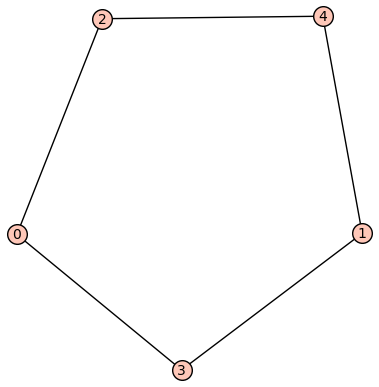

Graph 2: n=5, m=6


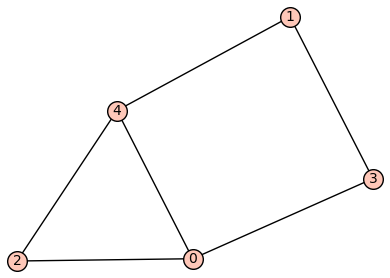

Graph 3: n=5, m=7


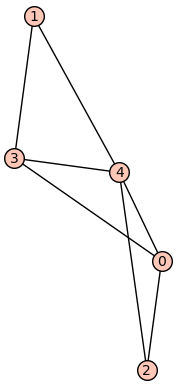

In [ ]:
def preview_graphs(filename='graphs_with_alpha_od_1.g6', count=3, start_index=0):
    """
    Show the first 'count' graphs from the file 'filename', starting from 'start_index'.
    """
    from sage.graphs.graph import Graph
    
    with open(filename, 'r') as f:
        for _ in range(start_index):
            next(f)  # skip to start_index

        for i, line in enumerate(f):
            if i >= count:
                break
            G = Graph(line.strip())
            print(f"Graph {i+1}: n={G.order()}, m={G.size()}")
            G.show()

preview_graphs(count=3, start_index=10)

## 4. Testiranje hipotez

Testirali bomo sledeče hipoteze.

In [ ]:
# Diameter properties

def prop_diameter_at_most_2(G):
   """
   H: Diameter of G is at most 2.
   """
   return G.diameter() <= 2

def prop_complement_diameter_at_most_2(G):
   """
   H: The complement of G has diameter at most 2.
   """
   return G.complement().diameter() <= 2

# Radius properties

def prop_radius_1(G):
   """
   H: Radius of G is equal to 1.
   """
   return G.radius() == 1

# Degree properties

def prop_min_degree_at_least_2(G):
   """
   H: G has minimum degree at least 2.
   """
   return min(G.degree()) >= 2

def prop_min_degree_at_least_n_div_2(G):
   """
   H: Minimum degree of G is at least n / 2.
   """
   return 2 * min(G.degree()) >= G.order()

def prop_average_degree_at_least_0_7_n(G):
   """
   H: Average degree of G is at least 0.7 * n
   """
   return G.average_degree() >= 0.7 * G.order()
   
def prop_regular(G):
   """
   H: G is regular.
   """
   return len(set(G.degree())) == 1

def prop_all_vertices_even_degree(G):
   """
   H: All vertices have even degree.
   """
   return all(d % 2 == 0 for d in G.degree())
   
def prop_all_vertices_odd_degree(G):
   """
   H: All vertices have even degree.
   """
   return all(d % 2 == 1 for d in G.degree())

# Vertex properties

def prop_no_twins(G):
   """
   H: No two vertices have identical neighborhoods.
   """
   neighborhoods = [frozenset(G.neighbors(v)) for v in G.vertices()]
   return len(set(neighborhoods)) == G.order()

def prop_has_perfect_matching(G):
   """
   H: G has a perfect matching.
   """
   if G.order() % 2 == 1:
      return False
   return G.has_perfect_matching()

# Forbidden subgraph properties

def prop_claw_free(G):
   """
   H: G is claw-free.
   """
   return is_claw_free(G)

def prop_triangle_free(G):
   """
   H: G is triangle-free (has no induced C3).
   """
   from sage.graphs.graph_generators import graphs

   return G.subgraph_search(graphs.CycleGraph(3), induced=True) is None

def prop_no_induced_P4(G):
   """
   H: G has no induced P4.
   """
   from sage.graphs.graph_generators import graphs

   return G.subgraph_search(graphs.PathGraph(4), induced=True) is None

def prop_no_induced_C4(G):
   """
   H: G has no induced C4.
   """
   from sage.graphs.graph_generators import graphs

   return G.subgraph_search(graphs.CycleGraph(4), induced=True) is None

def prop_no_induced_K4(G):
   """
   H: G has no induced K4.
   """
   from sage.graphs.graph_generators import graphs

   return G.subgraph_search(graphs.CompleteGraph(4), induced=True) is None

def prop_no_induced_odd_cycles_ge_5(G):
   """
   H: G has no induced odd cycles of length >= 5.
   """
   from sage.graphs.graph_generators import graphs

   n = G.order()
   for k in range(5, n + 1, 2):  # Odd cycles: 5, 7, 9, ...
      if G.subgraph_search(graphs.CycleGraph(k), induced=True) is not None:
         return False
   return True

# Girth properties

def prop_girth_at_least_5(G):
   """
   H: G has girth at least 5.
   """
   try:
      return G.girth() >= 5
   except:
      return True  # Acyclic graph

# Graph classes

def prop_bipartite(G):
   """
   H: G is bipartite.
   """
   return G.is_bipartite()

def prop_chordal(G):
   """
   H: G is chordal (no induced cycles of length >= 4).
   """
   return G.is_chordal()

def prop_line_graph(G):
   """
   H: G is a line graph.
   """
   return G.is_line_graph()

def prop_strongly_regular(G):
   """
   H: G is strongly regular.
   """
   return G.is_strongly_regular()

def prop_planar(G):
   """
   H: G is planar.
   """
   return G.is_planar()

# Connectivity properties

def prop_edge_connectivity_at_least_2(G):
   """
   H: Edge connectivity of G is at least 2.
   """
   return G.edge_connectivity() >= 2

def prop_vertex_connectivity_at_least_2(G):
   """
   H: Vertex connectivity of G is at least 2.
   Only computed for graphs with order <= 10.
   """
   if G.order() > 10:
      return None
   return G.vertex_connectivity() >= 2

def prop_complement_connected(G):
   """
   H: The complement of G is connected.
   """
   return G.complement().is_connected()

# Complementary properties

def prop_G_is_self_complementary(G):
   """
   H: G is equal to its complement.
   """
   return G.is_self_complementary()

# Independence number properties

def prop_alpha_less_than_n_half(G):
   """
   H: G has independence number less than n / 2.
   """
   return G.independent_set(value_only=True) <= G.order() / 2

def prop_alpha_equal_1(G):
   """
   H: G has independence number equal to 1.
   """
   return G.independent_set(value_only=True) == 1

def prop_alpha_square_equal_1(G):
   """
   H: alpha(G^2) == 1.
   The square graph G^2 has an independent set of size equal to 1.
   """
   return G.power(2).independent_set(value_only=True) == 1

# Coloring properties

def prop_chi_so_equals_n(G):
   """
   H: chi_so(G) = n (strong odd chromatic number equals order).
   Only computed for small graphs, since the computation is very slow.
   """
   if G.order() > 6 or G.size() > 20:
      return None  # Skip large graphs
   return chi_so(G) == G.order()

def prop_chromatic_number_at_most_3(G):
   """
   H: G has chromatic number at most 3.
   """
   if G.order() > 10 or G.size() > 50:
      return None  # Skip large graphs
   return G.chromatic_number() <= 3

# Edge density properties

def prop_density_at_least_0_6(G):
   """
   H: Edge density is at least 0.6.
   """
   n = G.order()
   max_edges = n * (n - 1) / 2
   return G.size() >= 0.6 * max_edges

def prop_density_between_0_4_and_0_6(G):
   """
   H: Edge density is between 0.4 and 0.6.
   """
   n = G.order()
   max_edges = n * (n - 1) / 2
   m = G.size()
   return m >= 0.4 * max_edges and m <= 0.6 * max_edges

# Interesting properties

def prop_hamiltonian(G):
   """
   H: G has a Hamiltonian cycle.
   """
   try:
      return G.is_hamiltonian()
   except:
      return False

def prop_eulerian(G):
   """
   H: G has an Eulerian cycle.
   """
   return G.is_eulerian()

Definirali bomo tudi funkciji, ki bosta preverjali potrebnost in pa zadostnost pogojev. Obe bomo združili in preverili vse hipoteze v funkciji `run_all_tests()`.

In [ ]:
def test_property_necessity(prop, prop_name, graphs_with_alpha_od_1, random_seed=42, double_print=print):
   """
   Test necessity: alpha_od(G) = 1  =>  prop(G)

   Searches for a list of counterexamples. If counterexamples is empty, then the property appears necessary. Prints statistics related to testing the property.
   """
   import random
   random.seed(int(random_seed))

   counterexamples = []
   stats = {}

   for G in graphs_with_alpha_od_1:
      n = G.order()

      if n not in stats:
         stats[n] = {"total": 0, "with_property": 0}
      stats[n]["total"] += 1

      prop_holds = prop(G)

      if prop_holds is None:
         continue

      if not prop_holds:
         counterexamples.append(G)
      else:
         stats[n]["with_property"] += 1

   double_print(f"Necessity test for {prop_name}")
   double_print(f"Tested {len(graphs_with_alpha_od_1)} graphs with alpha_od = 1.")
   double_print(f"Found {len(counterexamples)} counterexamples.")

   if counterexamples != []:
      double_print("Showing 3 random counterexamples:")
      num_to_show = min(3, len(counterexamples))
      example_graphs = random.sample(counterexamples, num_to_show)

      for graph in example_graphs:
         double_print(f"Counterexample graph in graph6 format: {graph.graph6_string()}")
         graph.show()
   else:
      double_print("No counterexamples found. The property appears necessary.")    
   
   double_print("\nStats (graphs with alpha_od=1 / satisfy property):")
   for n in sorted(stats.keys()):
      total = stats[n]["total"]
      with_property = stats[n]["with_property"]
      double_print(f"  n={n}: {total} / {with_property}")
   double_print()

def test_property_sufficiency(prop, prop_name, graphs_with_alpha_od_1, n_max=7, random_seed=42, double_print=print):
   """
   Test sufficiency: prop(G)  =>  alpha_od(G) = 1

   Returns a list of counterexamples. If the list is empty, then the property appears sufficient.
   """
   from sage.graphs.graph_generators import graphs
   import random
   random.seed(int(random_seed))

   counterexamples = []
   stats = {}

   for n in range(1, n_max + 1):
      if n not in stats:
         stats[n] = {"total": 0, "with_property": 0}

      for G in graphs(n, immutable=True):
         if not G.is_connected():
            continue

         prop_holds = prop(G)
         if prop_holds is None or not prop_holds: # We are looking for graphs with the property prop(G) == True
            continue

         stats[n]["total"] += 1

         if G in graphs_with_alpha_od_1:
            stats[n]["with_property"] += 1
         else:
            counterexamples.append(G)

   double_print(f"Sufficiency test for {prop_name}")
   double_print(f"Tested connected graphs with up to {n_max} vertices.")
   double_print(f"Found {len(counterexamples)} counterexamples.")

   if counterexamples != []:
      double_print("Showing 3 random counterexamples:")
      num_to_show = min(3, len(counterexamples))
      example_graphs = random.sample(counterexamples, num_to_show)

      for graph in example_graphs:
         double_print(f"Counterexample graph in graph6 format: {graph.graph6_string()}")
         graph.show()
   else:
      double_print("No counterexamples found. The property appears sufficient.")

   double_print("\nStats (graphs with property / have alpha_od=1):")
   for n in sorted(stats.keys()):
      total = stats[n]["total"]
      with_property = stats[n]["with_property"]
      double_print(f"  n={n}: {total} / {with_property}")
   double_print()

def run_all_tests(filename='graphs_with_alpha_od_1.g6', output_filename='test_results.txt', n_max=8):
   """
   Test necessity and sufficiency for each hypothesis. Print statistics to a test file.
   """

   with open(output_filename, 'w') as f:
      def double_print(text=''):
         """
         Print to console and write to file at the same time.
         """
         print(text)
         f.write(text + '\n')
      
      double_print(f"Loading graphs from {filename}...")
      graphs_with_alpha_od_1 = load_graphs_from_graph6(filename)
      double_print(f"Loaded {len(graphs_with_alpha_od_1)} graphs")

      properties = {
         # Diameter properties
         "Diameter at most 2": prop_diameter_at_most_2,
         "Complement diameter at most 2": prop_complement_diameter_at_most_2,

         # Radius properties
         "Radius 1": prop_radius_1,

         # Degree properties
         "Min degree at least 2": prop_min_degree_at_least_2,
         "Min degree at least n/2": prop_min_degree_at_least_n_div_2,
         "Average degree at least 0.7*n": prop_average_degree_at_least_0_7_n,
         "Regular": prop_regular,
	      "Even degree": prop_all_vertices_even_degree,
	      "Odd degree": prop_all_vertices_odd_degree,

	      # Vertex properties
	      "No twins": prop_no_twins,
	      "Perfect matching": prop_has_perfect_matching,

         # Forbidden subgraph properties
         "Claw-free": prop_claw_free,
         "Triangle-free": prop_triangle_free,
         "No induced P4": prop_no_induced_P4,
         "No induced C4": prop_no_induced_C4,
         "No induced K4": prop_no_induced_K4,
         "No induced odd cycles >= 5": prop_no_induced_odd_cycles_ge_5,

         # Girth properties
         "Girth at least 5": prop_girth_at_least_5,

         # Graph classes
         "Bipartite": prop_bipartite,
         "Chordal": prop_chordal,
         "Line graph": prop_line_graph,
         "Strongly regular": prop_strongly_regular,
         "Planar": prop_planar,

         # Connectivity properties
         "Edge connectivity at least 2": prop_edge_connectivity_at_least_2,
	      "Vertex connectivity at least 2": prop_vertex_connectivity_at_least_2,
         "Complement connected": prop_complement_connected,

	      # Complement properties
	      "Self complementary": prop_G_is_self_complementary,

         # Independence number properties
         "alpha(G) <= n/2": prop_alpha_less_than_n_half,
         "alpha(G) = 1": prop_alpha_equal_1,
         "alpha(G^2) == 1": prop_alpha_square_equal_1,

         # Coloring properties
         "chi_so(G) = n": prop_chi_so_equals_n,
         "chi(G) <= 3": prop_chromatic_number_at_most_3,

         # Edge density properties
         "Density at least 0.6": prop_density_at_least_0_6,
	      "Density between 0.4 and 0.6": prop_density_between_0_4_and_0_6,

         # Interesting properties
         "Hamiltonian": prop_hamiltonian,
         "Eulerian": prop_eulerian,
      }

      for name, prop in properties.items():
         double_print("="*70)
         double_print(f"Property: {name}")
         double_print("-"*70)

         test_property_necessity(prop, name, graphs_with_alpha_od_1, double_print=double_print)
         test_property_sufficiency(prop, name, graphs_with_alpha_od_1, n_max, double_print=double_print)

Loading graphs from graphs_with_alpha_od_1.g6...
Loaded 94456 graphs
Property: Diameter at most 2
----------------------------------------------------------------------
Necessity test for Diameter at most 2
Tested 94456 graphs with alpha_od = 1.
Found 0 counterexamples.
No counterexamples found. The property appears necessary.

Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 4 / 4
  n=5: 11 / 11
  n=6: 43 / 43
  n=7: 266 / 266
  n=8: 3042 / 3042
  n=9: 69645 / 69645
  n=10: 1072 / 1072
  n=11: 1049 / 1049
  n=12: 952 / 952
  n=13: 1062 / 1062
  n=14: 1002 / 1002
  n=15: 1015 / 1015
  n=16: 1004 / 1004
  n=17: 859 / 859
  n=18: 1126 / 1126
  n=19: 1078 / 1078
  n=20: 979 / 979
  n=21: 1011 / 1011
  n=22: 1065 / 1065
  n=23: 1144 / 1144
  n=24: 1000 / 1000
  n=25: 1183 / 1183
  n=26: 961 / 961
  n=27: 1035 / 1035
  n=28: 893 / 893
  n=29: 971 / 971
  n=30: 980 / 980

Sufficiency test for Diameter at most 2
Tested connected graphs with up t

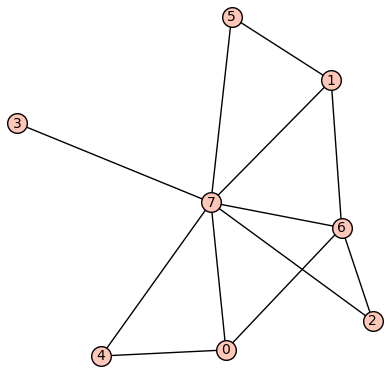

Counterexample graph in graph6 format: F?rvo


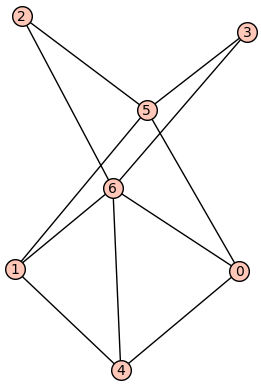

Counterexample graph in graph6 format: G?rdr{


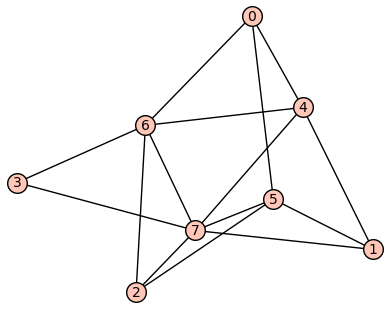


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 5 / 4
  n=5: 15 / 11
  n=6: 60 / 43
  n=7: 374 / 266
  n=8: 4155 / 3042

Property: Complement diameter at most 2
----------------------------------------------------------------------
Necessity test for Complement diameter at most 2
Tested 94456 graphs with alpha_od = 1.
Found 72688 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: HCvbvi}


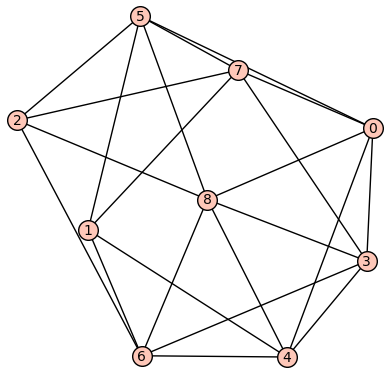

Counterexample graph in graph6 format: HCZVBzm


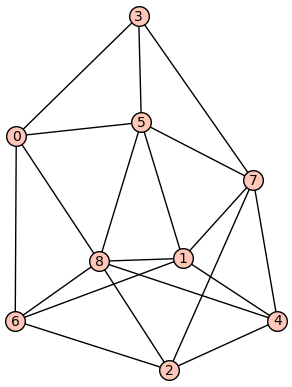

Counterexample graph in graph6 format: HCZJuiv


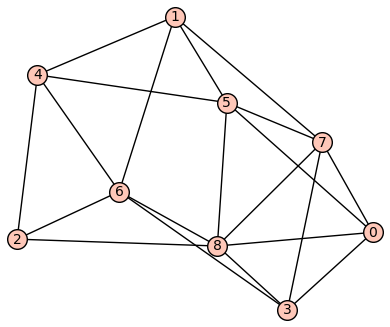


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 0
  n=3: 2 / 0
  n=4: 4 / 0
  n=5: 11 / 1
  n=6: 43 / 2
  n=7: 266 / 16
  n=8: 3042 / 186
  n=9: 69645 / 5042
  n=10: 1072 / 438
  n=11: 1049 / 484
  n=12: 952 / 487
  n=13: 1062 / 656
  n=14: 1002 / 609
  n=15: 1015 / 750
  n=16: 1004 / 707
  n=17: 859 / 632
  n=18: 1126 / 895
  n=19: 1078 / 868
  n=20: 979 / 772
  n=21: 1011 / 823
  n=22: 1065 / 940
  n=23: 1144 / 996
  n=24: 1000 / 883
  n=25: 1183 / 1084
  n=26: 961 / 903
  n=27: 1035 / 947
  n=28: 893 / 811
  n=29: 971 / 896
  n=30: 980 / 939

Sufficiency test for Complement diameter at most 2
Tested connected graphs with up to 8 vertices.
Found 2922 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: GCXeew


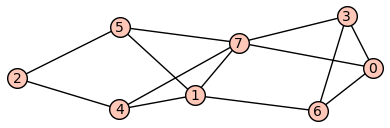

Counterexample graph in graph6 format: G?`Dbw


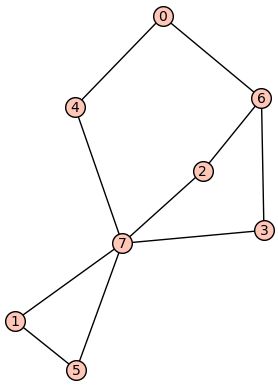

Counterexample graph in graph6 format: FCQuo


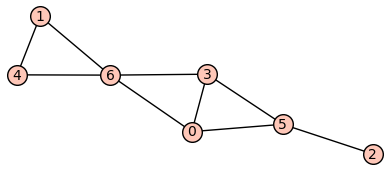


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 0 / 0
  n=3: 0 / 0
  n=4: 0 / 0
  n=5: 2 / 1
  n=6: 16 / 2
  n=7: 183 / 16
  n=8: 2926 / 186

Property: Radius 1
----------------------------------------------------------------------
Necessity test for Radius 1
Tested 94456 graphs with alpha_od = 1.
Found 86019 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: HEnfvqv


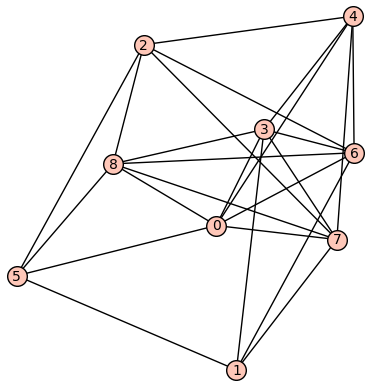

Counterexample graph in graph6 format: HCY]vrV


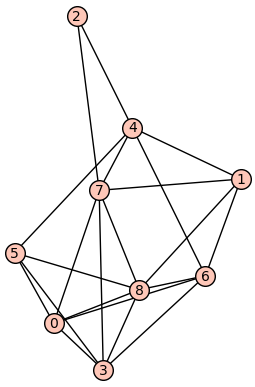

Counterexample graph in graph6 format: Jjy`keAf\R?


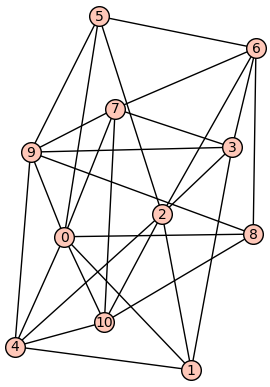


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 0
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 4 / 3
  n=5: 11 / 8
  n=6: 43 / 22
  n=7: 266 / 98
  n=8: 3042 / 633
  n=9: 69645 / 7627
  n=10: 1072 / 15
  n=11: 1049 / 14
  n=12: 952 / 5
  n=13: 1062 / 5
  n=14: 1002 / 4
  n=15: 1015 / 0
  n=16: 1004 / 0
  n=17: 859 / 0
  n=18: 1126 / 0
  n=19: 1078 / 0
  n=20: 979 / 0
  n=21: 1011 / 0
  n=22: 1065 / 0
  n=23: 1144 / 0
  n=24: 1000 / 0
  n=25: 1183 / 0
  n=26: 961 / 0
  n=27: 1035 / 0
  n=28: 893 / 0
  n=29: 971 / 0
  n=30: 980 / 0

Sufficiency test for Radius 1
Tested connected graphs with up to 8 vertices.
Found 485 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: G?q~~{


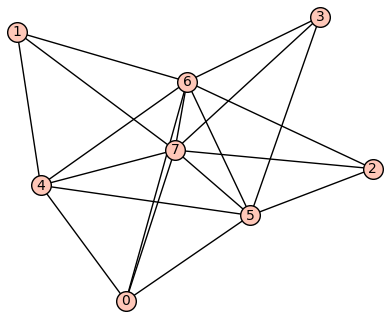

Counterexample graph in graph6 format: FCqnw


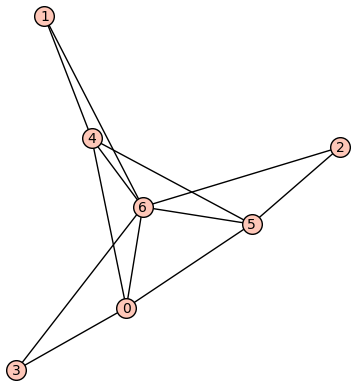

Counterexample graph in graph6 format: ECzw


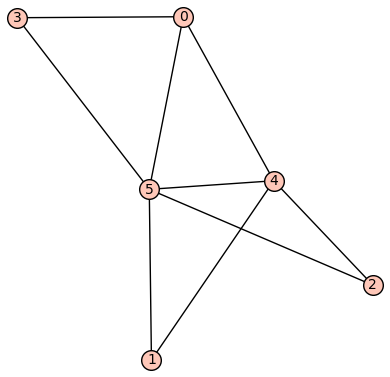


Stats (graphs with property / have alpha_od=1):
  n=1: 0 / 0
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 4 / 3
  n=5: 11 / 8
  n=6: 34 / 22
  n=7: 156 / 98
  n=8: 1044 / 633

Property: Min degree at least 2
----------------------------------------------------------------------
Necessity test for Min degree at least 2
Tested 94456 graphs with alpha_od = 1.
Found 331 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: HCe[}~~


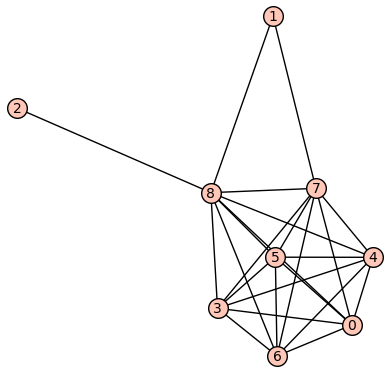

Counterexample graph in graph6 format: H?`e^Z~


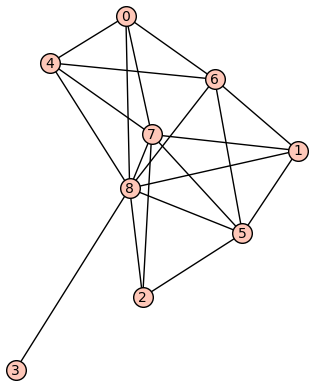

Counterexample graph in graph6 format: H?rNVJ~


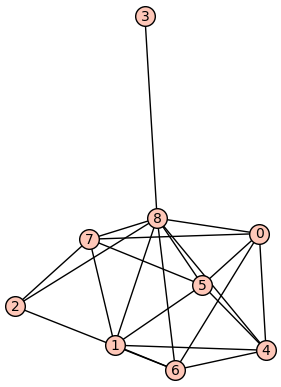


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 0
  n=2: 1 / 0
  n=3: 2 / 1
  n=4: 4 / 3
  n=5: 11 / 9
  n=6: 43 / 39
  n=7: 266 / 255
  n=8: 3042 / 2999
  n=9: 69645 / 69379
  n=10: 1072 / 1072
  n=11: 1049 / 1048
  n=12: 952 / 952
  n=13: 1062 / 1062
  n=14: 1002 / 1002
  n=15: 1015 / 1015
  n=16: 1004 / 1004
  n=17: 859 / 859
  n=18: 1126 / 1126
  n=19: 1078 / 1078
  n=20: 979 / 979
  n=21: 1011 / 1011
  n=22: 1065 / 1065
  n=23: 1144 / 1144
  n=24: 1000 / 1000
  n=25: 1183 / 1183
  n=26: 961 / 961
  n=27: 1035 / 1035
  n=28: 893 / 893
  n=29: 971 / 971
  n=30: 980 / 980

Sufficiency test for Min degree at least 2
Tested connected graphs with up to 8 vertices.
Found 4719 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: G?bvv{


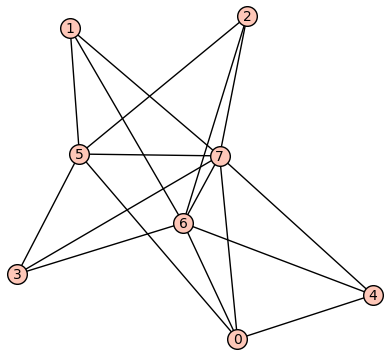

Counterexample graph in graph6 format: FC~vo


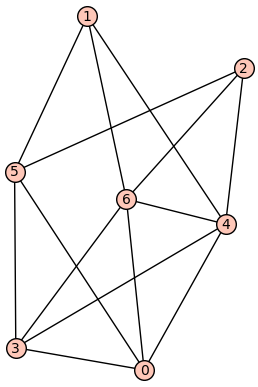

Counterexample graph in graph6 format: GCQdnW


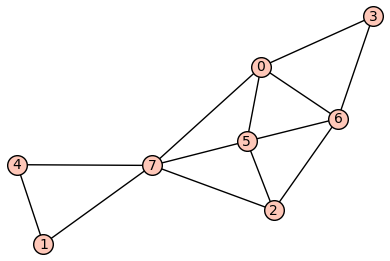


Stats (graphs with property / have alpha_od=1):
  n=1: 0 / 0
  n=2: 0 / 0
  n=3: 1 / 1
  n=4: 3 / 3
  n=5: 11 / 9
  n=6: 61 / 39
  n=7: 507 / 255
  n=8: 7442 / 2999

Property: Min degree at least n/2
----------------------------------------------------------------------
Necessity test for Min degree at least n/2
Tested 94456 graphs with alpha_od = 1.
Found 92972 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: H?aNbzm


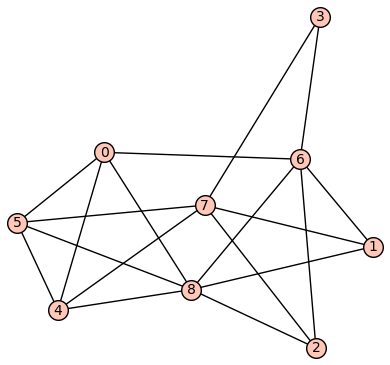

Counterexample graph in graph6 format: HCrbTz^


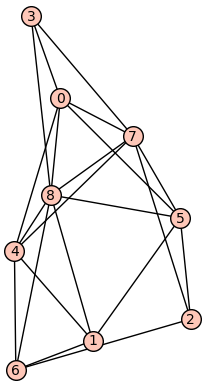

Counterexample graph in graph6 format: HCXfevu


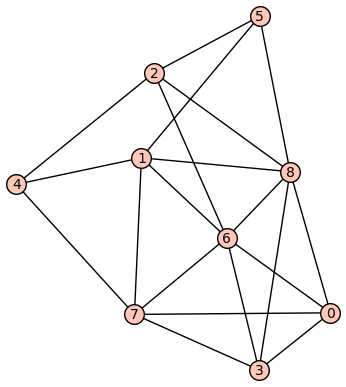


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 0
  n=2: 1 / 1
  n=3: 2 / 1
  n=4: 4 / 3
  n=5: 11 / 3
  n=6: 43 / 15
  n=7: 266 / 22
  n=8: 3042 / 367
  n=9: 69645 / 1017
  n=10: 1072 / 6
  n=11: 1049 / 1
  n=12: 952 / 4
  n=13: 1062 / 0
  n=14: 1002 / 0
  n=15: 1015 / 0
  n=16: 1004 / 0
  n=17: 859 / 0
  n=18: 1126 / 0
  n=19: 1078 / 0
  n=20: 979 / 0
  n=21: 1011 / 0
  n=22: 1065 / 0
  n=23: 1144 / 0
  n=24: 1000 / 2
  n=25: 1183 / 7
  n=26: 961 / 0
  n=27: 1035 / 8
  n=28: 893 / 11
  n=29: 971 / 0
  n=30: 980 / 16

Sufficiency test for Min degree at least n/2
Tested connected graphs with up to 8 vertices.
Found 68 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: G?~vf{


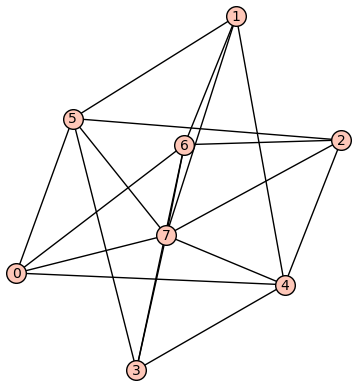

Counterexample graph in graph6 format: EF~w


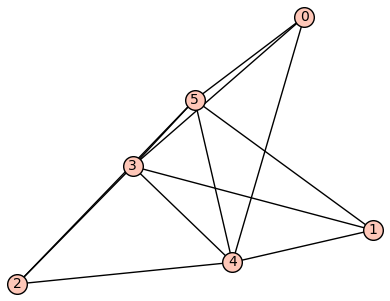

Counterexample graph in graph6 format: GC~vfo


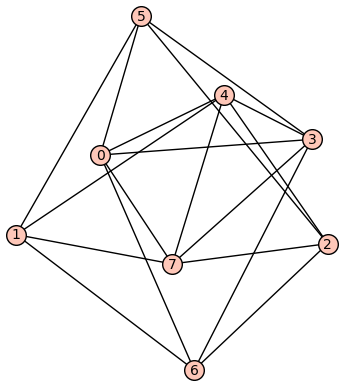


Stats (graphs with property / have alpha_od=1):
  n=1: 0 / 0
  n=2: 1 / 1
  n=3: 1 / 1
  n=4: 3 / 3
  n=5: 3 / 3
  n=6: 19 / 15
  n=7: 29 / 22
  n=8: 424 / 367

Property: Average degree at least 0.7*n
----------------------------------------------------------------------
Necessity test for Average degree at least 0.7*n
Tested 94456 graphs with alpha_od = 1.
Found 94177 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: HCQddf~


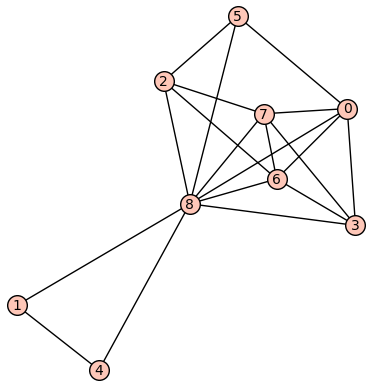

Counterexample graph in graph6 format: GQy~fW


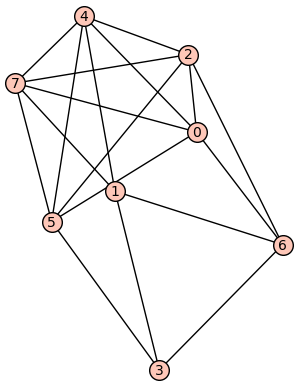

Counterexample graph in graph6 format: TcAJSxo_AIJG[aqo?sR_sinkalHXwK``CdXA


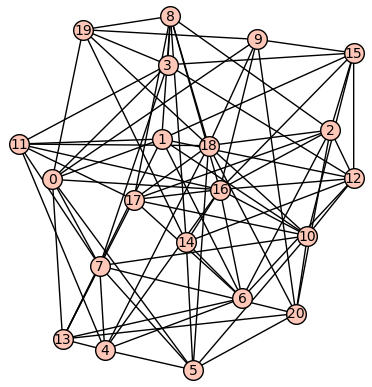


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 0
  n=2: 1 / 0
  n=3: 2 / 0
  n=4: 4 / 1
  n=5: 11 / 2
  n=6: 43 / 4
  n=7: 266 / 8
  n=8: 3042 / 39
  n=9: 69645 / 225
  n=10: 1072 / 0
  n=11: 1049 / 0
  n=12: 952 / 0
  n=13: 1062 / 0
  n=14: 1002 / 0
  n=15: 1015 / 0
  n=16: 1004 / 0
  n=17: 859 / 0
  n=18: 1126 / 0
  n=19: 1078 / 0
  n=20: 979 / 0
  n=21: 1011 / 0
  n=22: 1065 / 0
  n=23: 1144 / 0
  n=24: 1000 / 0
  n=25: 1183 / 0
  n=26: 961 / 0
  n=27: 1035 / 0
  n=28: 893 / 0
  n=29: 971 / 0
  n=30: 980 / 0

Sufficiency test for Average degree at least 0.7*n
Tested connected graphs with up to 8 vertices.
Found 6 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: GF~~~{


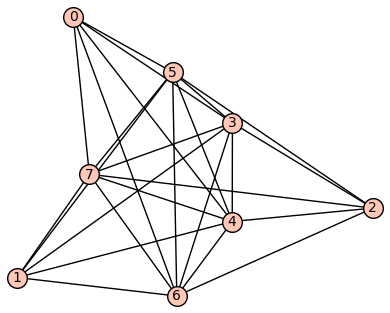

Counterexample graph in graph6 format: FF~~w


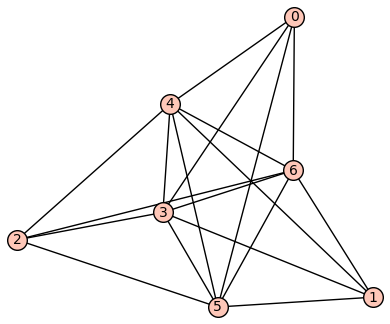

Counterexample graph in graph6 format: GFz~~{


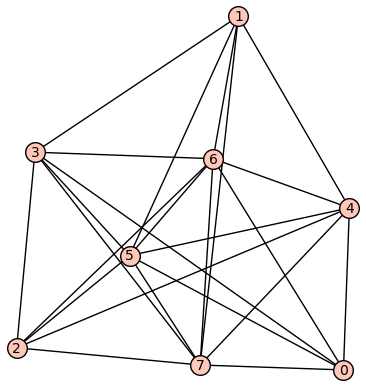


Stats (graphs with property / have alpha_od=1):
  n=1: 0 / 0
  n=2: 0 / 0
  n=3: 0 / 0
  n=4: 1 / 1
  n=5: 2 / 2
  n=6: 4 / 4
  n=7: 9 / 8
  n=8: 44 / 39

Property: Regular
----------------------------------------------------------------------
Necessity test for Regular
Tested 94456 graphs with alpha_od = 1.
Found 94416 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: HCRVvj~


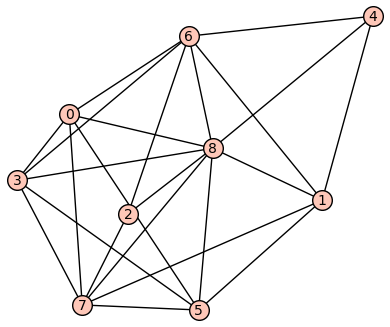

Counterexample graph in graph6 format: HEhrvNf


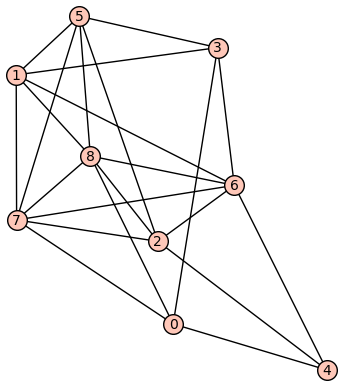

Counterexample graph in graph6 format: HTnvvnv


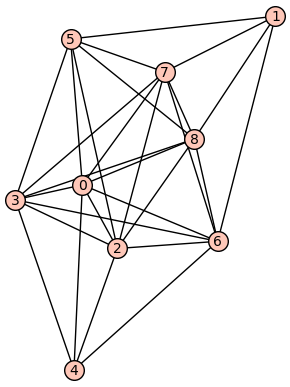


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 1
  n=4: 4 / 2
  n=5: 11 / 2
  n=6: 43 / 3
  n=7: 266 / 2
  n=8: 3042 / 10
  n=9: 69645 / 18
  n=10: 1072 / 0
  n=11: 1049 / 0
  n=12: 952 / 0
  n=13: 1062 / 0
  n=14: 1002 / 0
  n=15: 1015 / 0
  n=16: 1004 / 0
  n=17: 859 / 0
  n=18: 1126 / 0
  n=19: 1078 / 0
  n=20: 979 / 0
  n=21: 1011 / 0
  n=22: 1065 / 0
  n=23: 1144 / 0
  n=24: 1000 / 0
  n=25: 1183 / 0
  n=26: 961 / 0
  n=27: 1035 / 0
  n=28: 893 / 0
  n=29: 971 / 0
  n=30: 980 / 0

Sufficiency test for Regular
Tested connected graphs with up to 8 vertices.
Found 11 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: GFzvvW


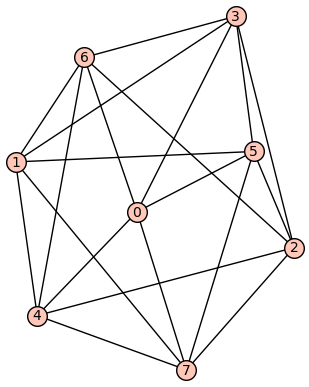

Counterexample graph in graph6 format: EFz_


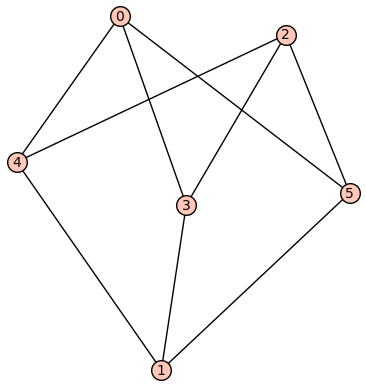

Counterexample graph in graph6 format: EEh_


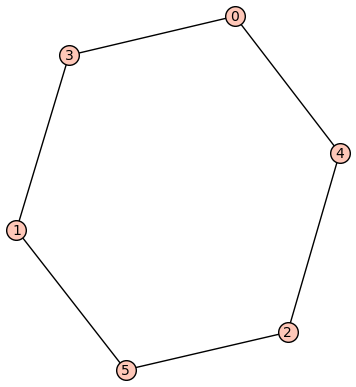


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 1 / 1
  n=4: 2 / 2
  n=5: 2 / 2
  n=6: 5 / 3
  n=7: 4 / 2
  n=8: 17 / 10

Property: Even degree
----------------------------------------------------------------------
Necessity test for Even degree
Tested 94456 graphs with alpha_od = 1.
Found 93853 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: H?rfe}~


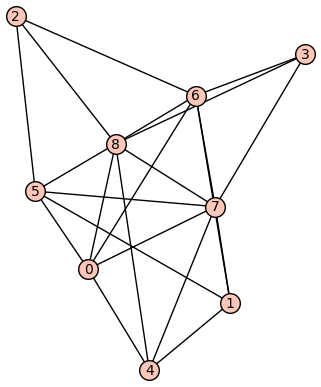

Counterexample graph in graph6 format: KHS]^rCdZSiD


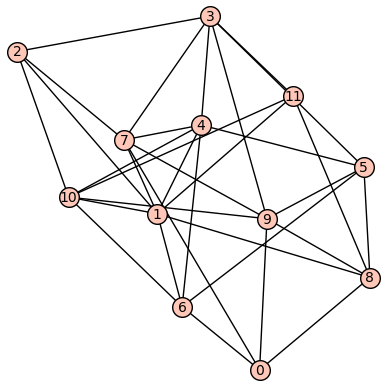

Counterexample graph in graph6 format: H?`uTvl


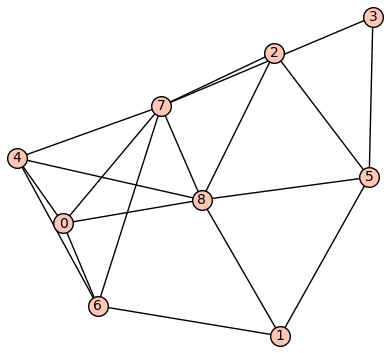


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 0
  n=3: 2 / 1
  n=4: 4 / 1
  n=5: 11 / 3
  n=6: 43 / 4
  n=7: 266 / 13
  n=8: 3042 / 60
  n=9: 69645 / 509
  n=10: 1072 / 7
  n=11: 1049 / 2
  n=12: 952 / 2
  n=13: 1062 / 0
  n=14: 1002 / 0
  n=15: 1015 / 0
  n=16: 1004 / 0
  n=17: 859 / 0
  n=18: 1126 / 0
  n=19: 1078 / 0
  n=20: 979 / 0
  n=21: 1011 / 0
  n=22: 1065 / 0
  n=23: 1144 / 0
  n=24: 1000 / 0
  n=25: 1183 / 0
  n=26: 961 / 0
  n=27: 1035 / 0
  n=28: 893 / 0
  n=29: 971 / 0
  n=30: 980 / 0

Sufficiency test for Even degree
Tested connected graphs with up to 8 vertices.
Found 153 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: FQzUW


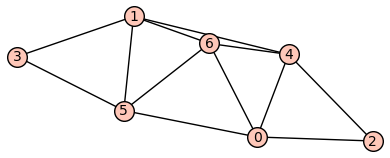

Counterexample graph in graph6 format: F?`vw


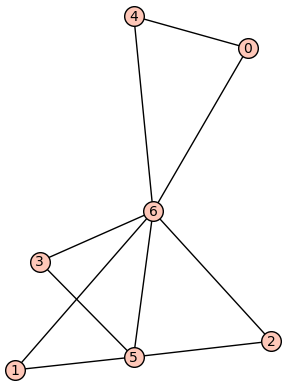

Counterexample graph in graph6 format: G?ouXw


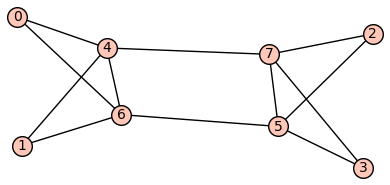


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 0 / 0
  n=3: 1 / 1
  n=4: 1 / 1
  n=5: 4 / 3
  n=6: 8 / 4
  n=7: 37 / 13
  n=8: 184 / 60

Property: Odd degree
----------------------------------------------------------------------
Necessity test for Odd degree
Tested 94456 graphs with alpha_od = 1.
Found 94391 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: HCrVvt~


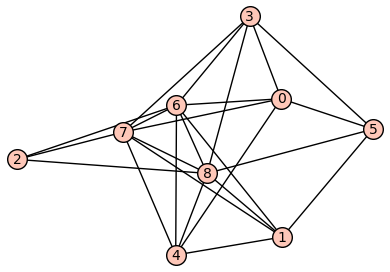

Counterexample graph in graph6 format: HEhrvNf


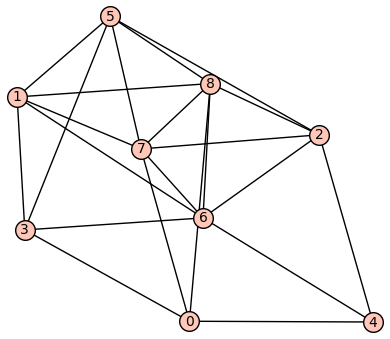

Counterexample graph in graph6 format: H?bvVpy


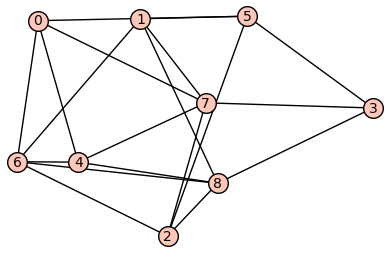


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 0
  n=2: 1 / 1
  n=3: 2 / 0
  n=4: 4 / 1
  n=5: 11 / 0
  n=6: 43 / 5
  n=7: 266 / 0
  n=8: 3042 / 57
  n=9: 69645 / 0
  n=10: 1072 / 0
  n=11: 1049 / 0
  n=12: 952 / 0
  n=13: 1062 / 0
  n=14: 1002 / 1
  n=15: 1015 / 0
  n=16: 1004 / 0
  n=17: 859 / 0
  n=18: 1126 / 0
  n=19: 1078 / 0
  n=20: 979 / 0
  n=21: 1011 / 0
  n=22: 1065 / 0
  n=23: 1144 / 0
  n=24: 1000 / 0
  n=25: 1183 / 0
  n=26: 961 / 0
  n=27: 1035 / 0
  n=28: 893 / 0
  n=29: 971 / 0
  n=30: 980 / 0

Sufficiency test for Odd degree
Tested connected graphs with up to 8 vertices.
Found 176 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: GEjvc{


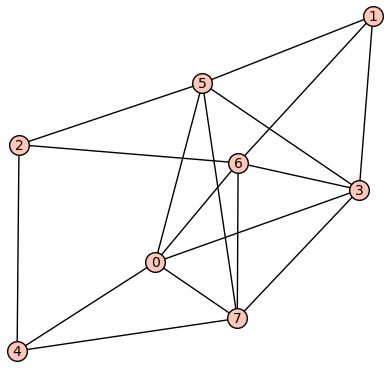

Counterexample graph in graph6 format: G?B~vo


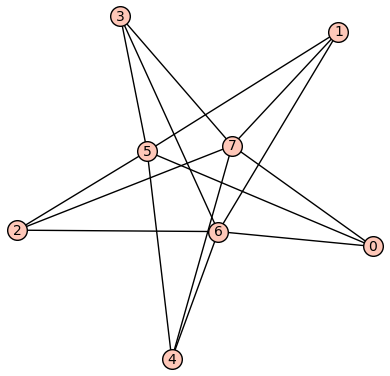

Counterexample graph in graph6 format: EEzO


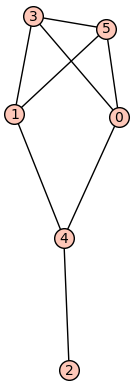


Stats (graphs with property / have alpha_od=1):
  n=1: 0 / 0
  n=2: 1 / 1
  n=3: 0 / 0
  n=4: 2 / 1
  n=5: 0 / 0
  n=6: 13 / 5
  n=7: 0 / 0
  n=8: 224 / 57

Property: No twins
----------------------------------------------------------------------
Necessity test for No twins
Tested 94456 graphs with alpha_od = 1.
Found 13406 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: HCZ^vq~


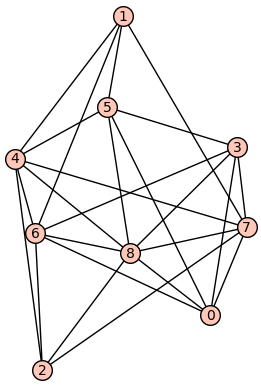

Counterexample graph in graph6 format: HCXfVh}


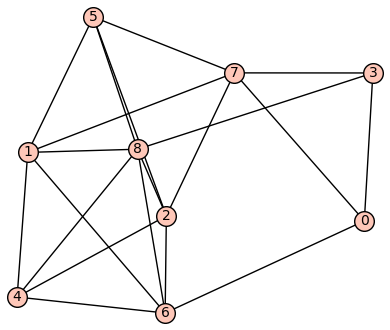

Counterexample graph in graph6 format: HCxvfz}


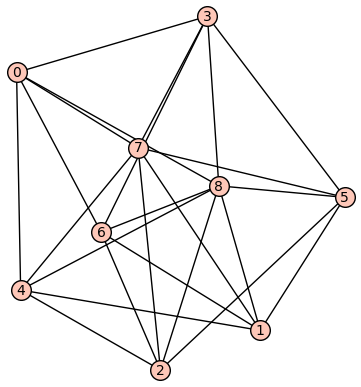


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 1
  n=4: 4 / 2
  n=5: 11 / 7
  n=6: 43 / 27
  n=7: 266 / 183
  n=8: 3042 / 2287
  n=9: 69645 / 57359
  n=10: 1072 / 977
  n=11: 1049 / 974
  n=12: 952 / 917
  n=13: 1062 / 1037
  n=14: 1002 / 993
  n=15: 1015 / 1008
  n=16: 1004 / 997
  n=17: 859 / 856
  n=18: 1126 / 1126
  n=19: 1078 / 1077
  n=20: 979 / 979
  n=21: 1011 / 1011
  n=22: 1065 / 1065
  n=23: 1144 / 1144
  n=24: 1000 / 1000
  n=25: 1183 / 1183
  n=26: 961 / 961
  n=27: 1035 / 1035
  n=28: 893 / 893
  n=29: 971 / 969
  n=30: 980 / 980

Sufficiency test for No twins
Tested connected graphs with up to 8 vertices.
Found 5518 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: GEhffc


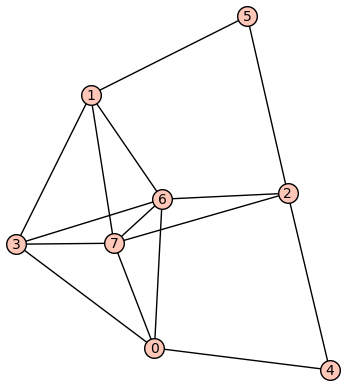

Counterexample graph in graph6 format: G?`ang


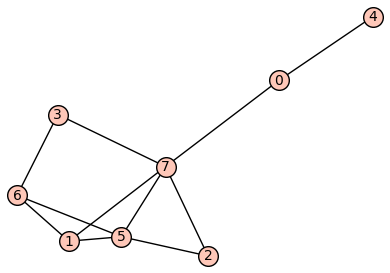

Counterexample graph in graph6 format: FCrJo


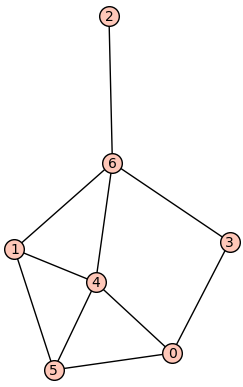


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 1 / 1
  n=4: 3 / 2
  n=5: 11 / 7
  n=6: 61 / 27
  n=7: 507 / 183
  n=8: 7442 / 2287

Property: Perfect matching
----------------------------------------------------------------------
Necessity test for Perfect matching
Tested 94456 graphs with alpha_od = 1.
Found 80333 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: HCrj~n~


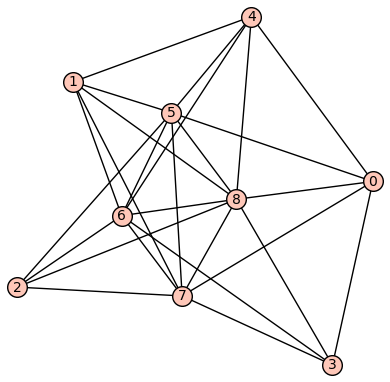

Counterexample graph in graph6 format: H?qvMr~


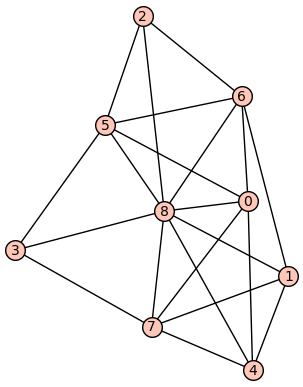

Counterexample graph in graph6 format: HCQv^zz


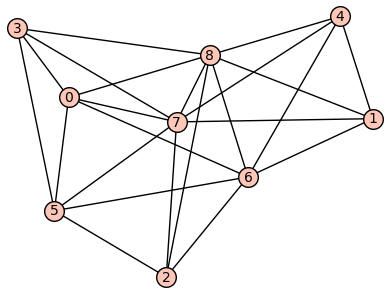


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 0
  n=2: 1 / 1
  n=3: 2 / 0
  n=4: 4 / 4
  n=5: 11 / 0
  n=6: 43 / 43
  n=7: 266 / 0
  n=8: 3042 / 3041
  n=9: 69645 / 0
  n=10: 1072 / 1072
  n=11: 1049 / 0
  n=12: 952 / 952
  n=13: 1062 / 0
  n=14: 1002 / 1002
  n=15: 1015 / 0
  n=16: 1004 / 1004
  n=17: 859 / 0
  n=18: 1126 / 1126
  n=19: 1078 / 0
  n=20: 979 / 979
  n=21: 1011 / 0
  n=22: 1065 / 1065
  n=23: 1144 / 0
  n=24: 1000 / 1000
  n=25: 1183 / 0
  n=26: 961 / 961
  n=27: 1035 / 0
  n=28: 893 / 893
  n=29: 971 / 0
  n=30: 980 / 980

Sufficiency test for Perfect matching
Tested connected graphs with up to 8 vertices.
Found 7309 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: GCpe^o


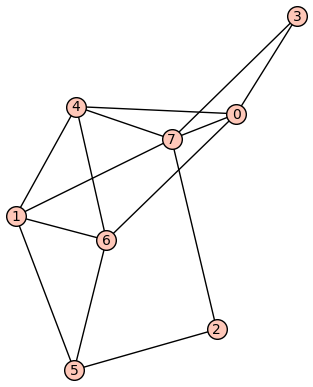

Counterexample graph in graph6 format: G?`ems


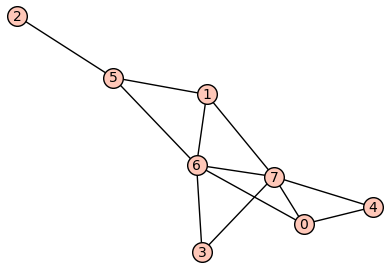

Counterexample graph in graph6 format: G?`Dvw


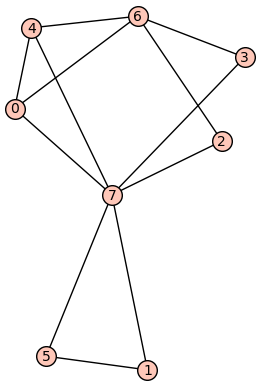


Stats (graphs with property / have alpha_od=1):
  n=1: 0 / 0
  n=2: 1 / 1
  n=3: 0 / 0
  n=4: 5 / 4
  n=5: 0 / 0
  n=6: 95 / 43
  n=7: 0 / 0
  n=8: 10297 / 3041

Property: Claw-free
----------------------------------------------------------------------
Necessity test for Claw-free
Tested 94456 graphs with alpha_od = 1.
Found 91595 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: ToDmfxVwb@CTel~sz\@F@bP}SysQoy^\Z?Ws


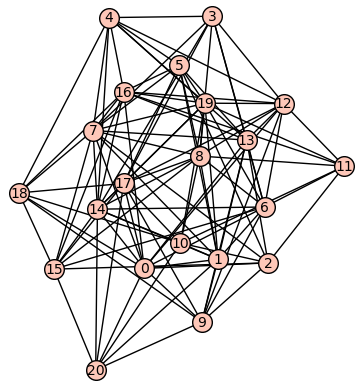

Counterexample graph in graph6 format: HQjRfj|


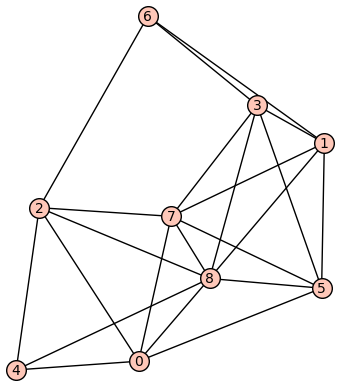

Counterexample graph in graph6 format: HCXfZz~


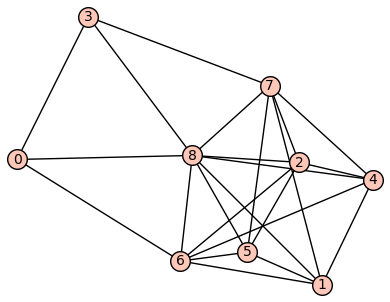


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 4 / 4
  n=5: 11 / 10
  n=6: 43 / 29
  n=7: 266 / 100
  n=8: 3042 / 434
  n=9: 69645 / 2280
  n=10: 1072 / 0
  n=11: 1049 / 0
  n=12: 952 / 0
  n=13: 1062 / 0
  n=14: 1002 / 0
  n=15: 1015 / 0
  n=16: 1004 / 0
  n=17: 859 / 0
  n=18: 1126 / 0
  n=19: 1078 / 0
  n=20: 979 / 0
  n=21: 1011 / 0
  n=22: 1065 / 0
  n=23: 1144 / 0
  n=24: 1000 / 0
  n=25: 1183 / 0
  n=26: 961 / 0
  n=27: 1035 / 0
  n=28: 893 / 0
  n=29: 971 / 0
  n=30: 980 / 0

Sufficiency test for Claw-free
Tested connected graphs with up to 8 vertices.
Found 564 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: FQzmw


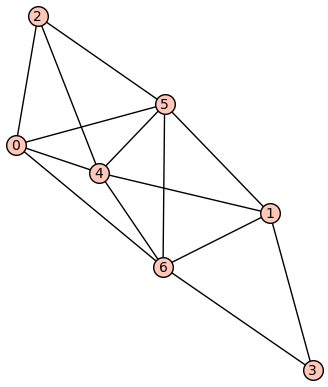

Counterexample graph in graph6 format: ETno


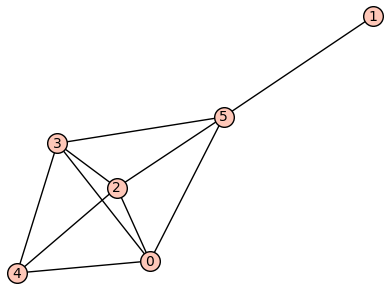

Counterexample graph in graph6 format: GCp`eo


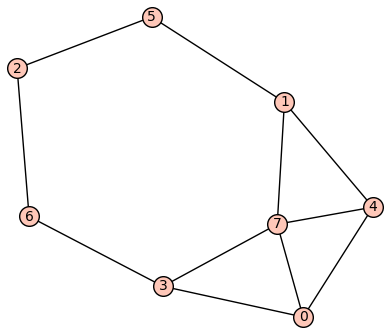


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 5 / 4
  n=5: 14 / 10
  n=6: 50 / 29
  n=7: 191 / 100
  n=8: 881 / 434

Property: Triangle-free
----------------------------------------------------------------------
Necessity test for Triangle-free
Tested 94456 graphs with alpha_od = 1.
Found 94442 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: HCXm^a}


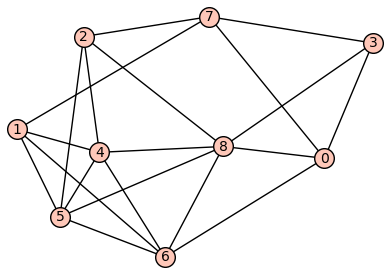

Counterexample graph in graph6 format: HCZJzzu


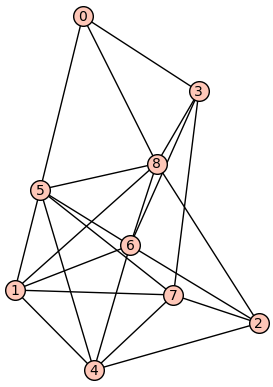

Counterexample graph in graph6 format: H?bvVpy


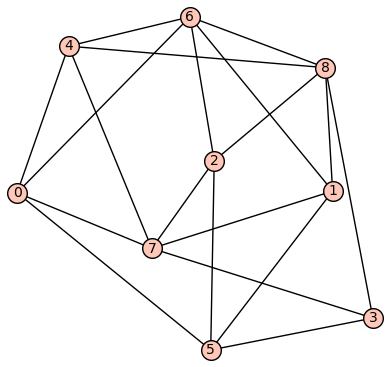


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 1
  n=4: 4 / 1
  n=5: 11 / 1
  n=6: 43 / 1
  n=7: 266 / 2
  n=8: 3042 / 3
  n=9: 69645 / 3
  n=10: 1072 / 0
  n=11: 1049 / 0
  n=12: 952 / 0
  n=13: 1062 / 0
  n=14: 1002 / 0
  n=15: 1015 / 0
  n=16: 1004 / 0
  n=17: 859 / 0
  n=18: 1126 / 0
  n=19: 1078 / 0
  n=20: 979 / 0
  n=21: 1011 / 0
  n=22: 1065 / 0
  n=23: 1144 / 0
  n=24: 1000 / 0
  n=25: 1183 / 0
  n=26: 961 / 0
  n=27: 1035 / 0
  n=28: 893 / 0
  n=29: 971 / 0
  n=30: 980 / 0

Sufficiency test for Triangle-free
Tested connected graphs with up to 8 vertices.
Found 346 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: G?zTb_


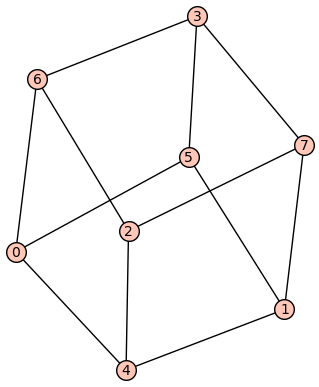

Counterexample graph in graph6 format: F?ov_


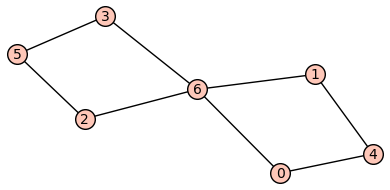

Counterexample graph in graph6 format: E?zO


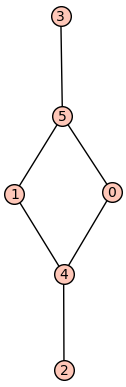


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 1 / 1
  n=4: 3 / 1
  n=5: 6 / 1
  n=6: 19 / 1
  n=7: 59 / 2
  n=8: 267 / 3

Property: No induced P4
----------------------------------------------------------------------
Necessity test for No induced P4
Tested 94456 graphs with alpha_od = 1.
Found 93987 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: H?o~TvV


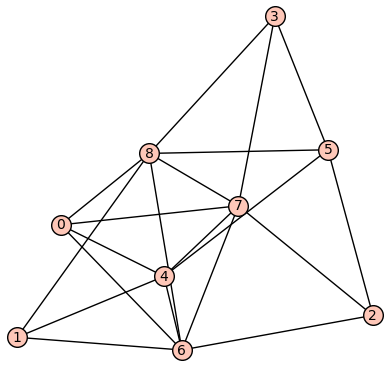

Counterexample graph in graph6 format: H?qrdZ^


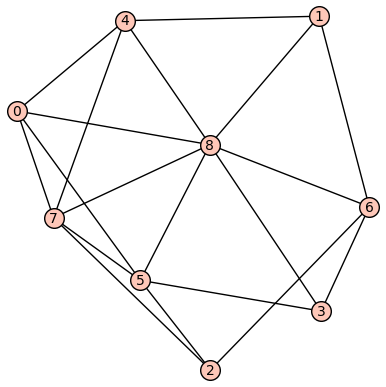

Counterexample graph in graph6 format: YkWNZ^EPSRgsfGI~Lsmp]obK{BiLVxeqIII_oRXGtWNbAmHEjcD~VEF_


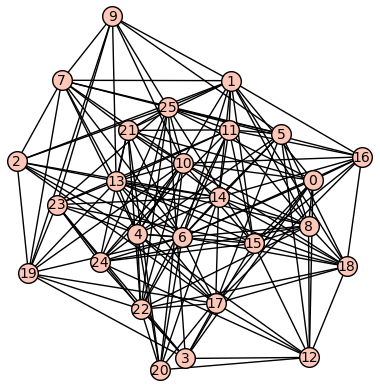


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 4 / 4
  n=5: 11 / 8
  n=6: 43 / 19
  n=7: 266 / 44
  n=8: 3042 / 111
  n=9: 69645 / 279
  n=10: 1072 / 0
  n=11: 1049 / 0
  n=12: 952 / 0
  n=13: 1062 / 0
  n=14: 1002 / 0
  n=15: 1015 / 0
  n=16: 1004 / 0
  n=17: 859 / 0
  n=18: 1126 / 0
  n=19: 1078 / 0
  n=20: 979 / 0
  n=21: 1011 / 0
  n=22: 1065 / 0
  n=23: 1144 / 0
  n=24: 1000 / 0
  n=25: 1183 / 0
  n=26: 961 / 0
  n=27: 1035 / 0
  n=28: 893 / 0
  n=29: 971 / 0
  n=30: 980 / 0

Sufficiency test for No induced P4
Tested connected graphs with up to 8 vertices.
Found 215 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: G?~vfw


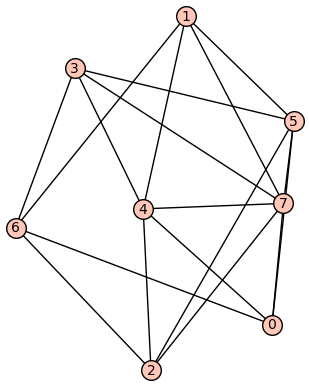

Counterexample graph in graph6 format: F?aNw


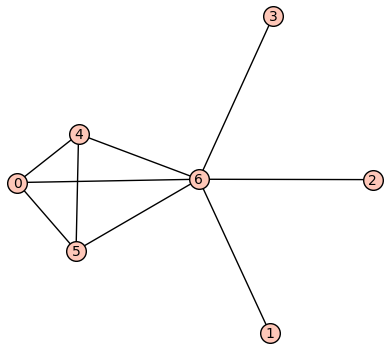

Counterexample graph in graph6 format: E?bw


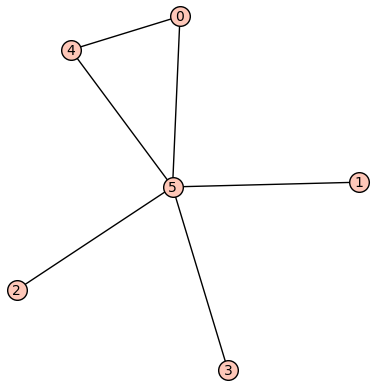


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 5 / 4
  n=5: 12 / 8
  n=6: 33 / 19
  n=7: 90 / 44
  n=8: 261 / 111

Property: No induced C4
----------------------------------------------------------------------
Necessity test for No induced C4
Tested 94456 graphs with alpha_od = 1.
Found 92857 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: HCRbcrn


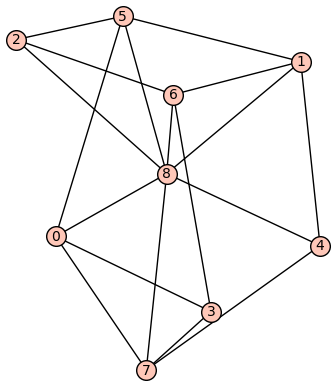

Counterexample graph in graph6 format: H?qvVt~


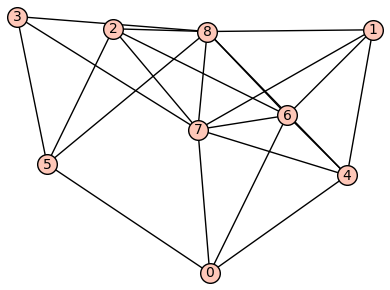

Counterexample graph in graph6 format: HCQtn^}


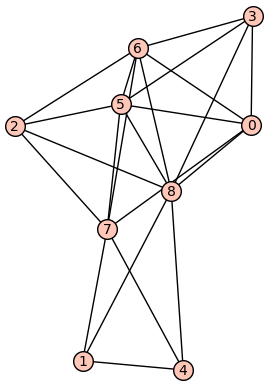


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 4 / 3
  n=5: 11 / 8
  n=6: 43 / 19
  n=7: 266 / 62
  n=8: 3042 / 240
  n=9: 69645 / 1261
  n=10: 1072 / 2
  n=11: 1049 / 0
  n=12: 952 / 0
  n=13: 1062 / 0
  n=14: 1002 / 0
  n=15: 1015 / 0
  n=16: 1004 / 0
  n=17: 859 / 0
  n=18: 1126 / 0
  n=19: 1078 / 0
  n=20: 979 / 0
  n=21: 1011 / 0
  n=22: 1065 / 0
  n=23: 1144 / 0
  n=24: 1000 / 0
  n=25: 1183 / 0
  n=26: 961 / 0
  n=27: 1035 / 0
  n=28: 893 / 0
  n=29: 971 / 0
  n=30: 980 / 0

Sufficiency test for No induced C4
Tested connected graphs with up to 8 vertices.
Found 2079 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: G?BDts


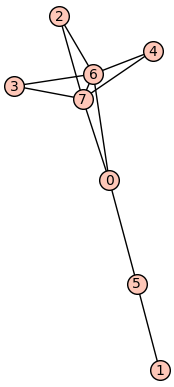

Counterexample graph in graph6 format: F?bLw


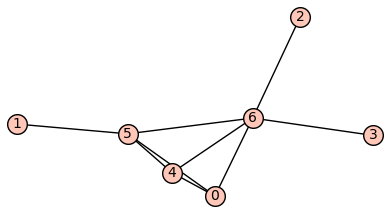

Counterexample graph in graph6 format: G?qacW


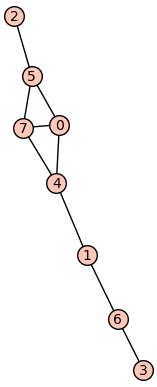


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 5 / 3
  n=5: 16 / 8
  n=6: 63 / 19
  n=7: 313 / 62
  n=8: 2014 / 240

Property: No induced K4
----------------------------------------------------------------------
Necessity test for No induced K4
Tested 94456 graphs with alpha_od = 1.
Found 82383 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: HCZT|~^


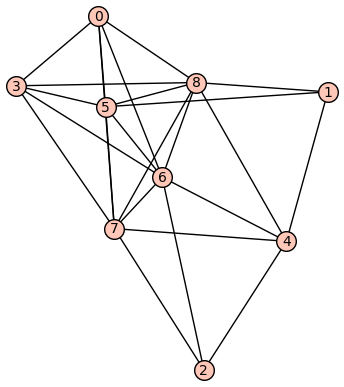

Counterexample graph in graph6 format: WZB\|qZWp[@vv}FiwfNlM|_lo^UVfHR?fqApVpcnasd{ApI


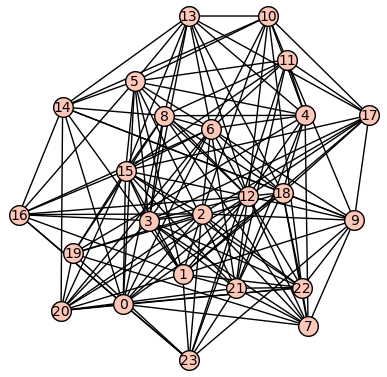

Counterexample graph in graph6 format: HEhffY~


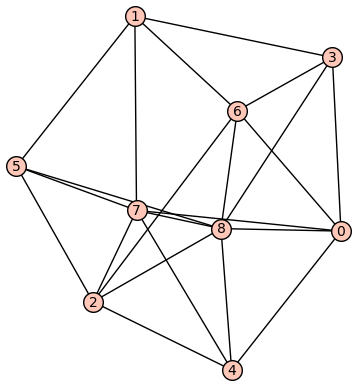


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 4 / 3
  n=5: 11 / 7
  n=6: 43 / 22
  n=7: 266 / 98
  n=8: 3042 / 746
  n=9: 69645 / 10123
  n=10: 1072 / 380
  n=11: 1049 / 253
  n=12: 952 / 133
  n=13: 1062 / 119
  n=14: 1002 / 72
  n=15: 1015 / 59
  n=16: 1004 / 26
  n=17: 859 / 14
  n=18: 1126 / 8
  n=19: 1078 / 3
  n=20: 979 / 0
  n=21: 1011 / 0
  n=22: 1065 / 0
  n=23: 1144 / 0
  n=24: 1000 / 2
  n=25: 1183 / 0
  n=26: 961 / 1
  n=27: 1035 / 0
  n=28: 893 / 0
  n=29: 971 / 0
  n=30: 980 / 0

Sufficiency test for No induced K4
Tested connected graphs with up to 8 vertices.
Found 5370 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: GCdbMg


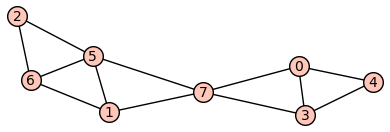

Counterexample graph in graph6 format: G?Bfe{


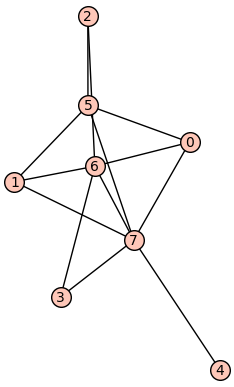

Counterexample graph in graph6 format: F?qtw


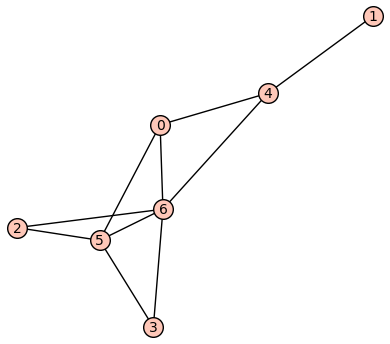


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 5 / 3
  n=5: 17 / 7
  n=6: 82 / 22
  n=7: 536 / 98
  n=8: 5606 / 746

Property: No induced odd cycles >= 5
----------------------------------------------------------------------
Necessity test for No induced odd cycles >= 5
Tested 94456 graphs with alpha_od = 1.
Found 66187 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: HCZLfV^


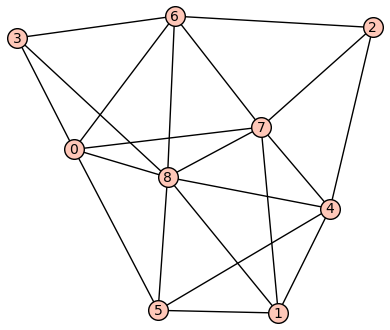

Counterexample graph in graph6 format: T{nfsIO?LAW@cKcdPbMB?aIedGVM_LEWKCP{


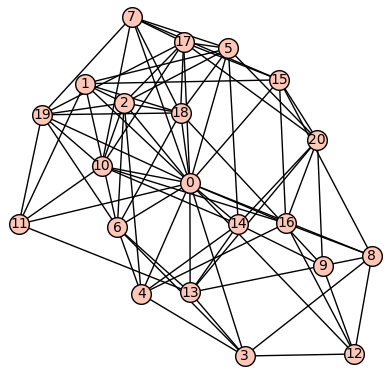

Counterexample graph in graph6 format: HQjRaxv


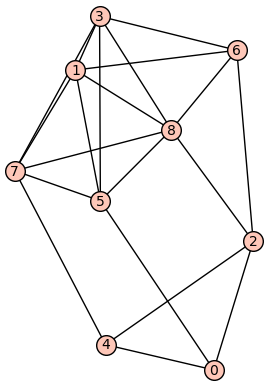


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 4 / 4
  n=5: 11 / 10
  n=6: 43 / 38
  n=7: 266 / 204
  n=8: 3042 / 1809
  n=9: 69645 / 26107
  n=10: 1072 / 59
  n=11: 1049 / 26
  n=12: 952 / 7
  n=13: 1062 / 1
  n=14: 1002 / 0
  n=15: 1015 / 0
  n=16: 1004 / 0
  n=17: 859 / 0
  n=18: 1126 / 0
  n=19: 1078 / 0
  n=20: 979 / 0
  n=21: 1011 / 0
  n=22: 1065 / 0
  n=23: 1144 / 0
  n=24: 1000 / 0
  n=25: 1183 / 0
  n=26: 961 / 0
  n=27: 1035 / 0
  n=28: 893 / 0
  n=29: 971 / 0
  n=30: 980 / 0

Sufficiency test for No induced odd cycles >= 5
Tested connected graphs with up to 8 vertices.
Found 6607 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: GCre^S


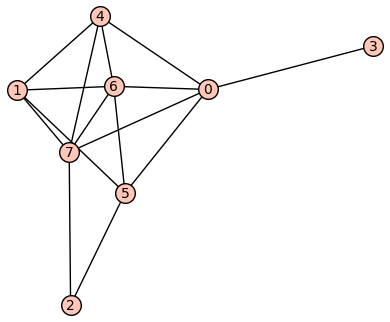

Counterexample graph in graph6 format: G?BDn{


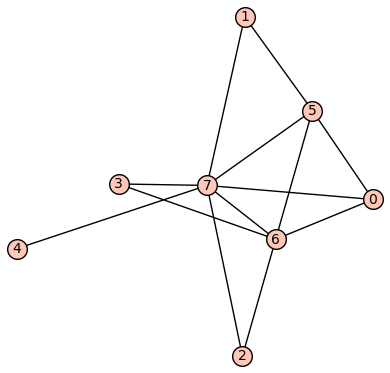

Counterexample graph in graph6 format: F?qvg


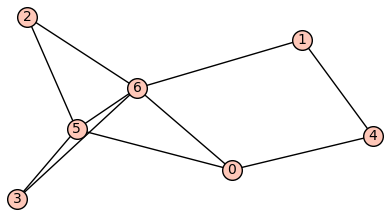


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 6 / 4
  n=5: 20 / 10
  n=6: 105 / 38
  n=7: 725 / 204
  n=8: 7816 / 1809

Property: Girth at least 5
----------------------------------------------------------------------
Necessity test for Girth at least 5
Tested 94456 graphs with alpha_od = 1.
Found 94452 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: [PeM\k\gEaNKoOjFQH~qsxyocB\}ro{sfAW|vtv[]VcEFFO?lhMEfkibOKFAO{Zi


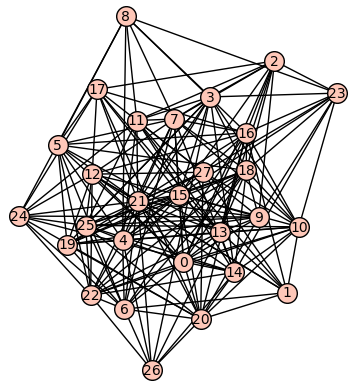

Counterexample graph in graph6 format: LQa^fRP|FW?ic`


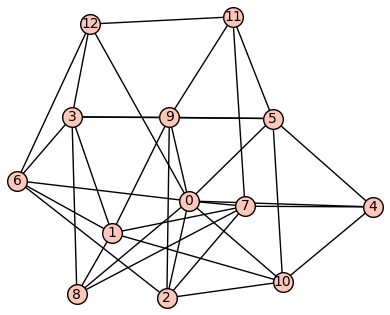

Counterexample graph in graph6 format: H?bvVpy


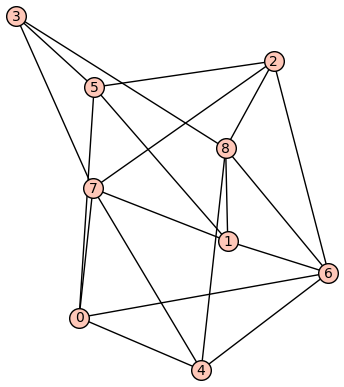


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 1
  n=4: 4 / 0
  n=5: 11 / 1
  n=6: 43 / 0
  n=7: 266 / 0
  n=8: 3042 / 0
  n=9: 69645 / 0
  n=10: 1072 / 0
  n=11: 1049 / 0
  n=12: 952 / 0
  n=13: 1062 / 0
  n=14: 1002 / 0
  n=15: 1015 / 0
  n=16: 1004 / 0
  n=17: 859 / 0
  n=18: 1126 / 0
  n=19: 1078 / 0
  n=20: 979 / 0
  n=21: 1011 / 0
  n=22: 1065 / 0
  n=23: 1144 / 0
  n=24: 1000 / 0
  n=25: 1183 / 0
  n=26: 961 / 0
  n=27: 1035 / 0
  n=28: 893 / 0
  n=29: 971 / 0
  n=30: 980 / 0

Sufficiency test for Girth at least 5
Tested connected graphs with up to 8 vertices.
Found 78 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: F?AFo


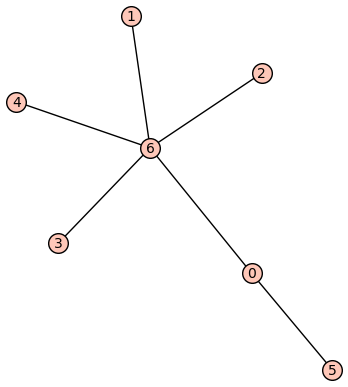

Counterexample graph in graph6 format: DCw


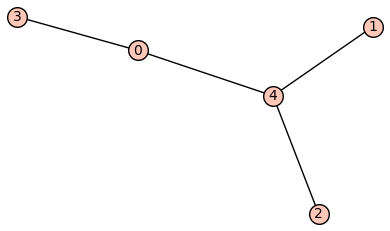

Counterexample graph in graph6 format: G??FCw


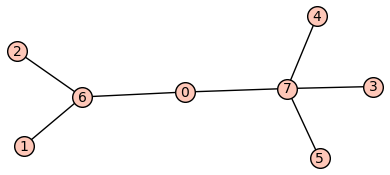


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 1 / 1
  n=4: 2 / 0
  n=5: 4 / 1
  n=6: 8 / 0
  n=7: 18 / 0
  n=8: 47 / 0

Property: Bipartite
----------------------------------------------------------------------
Necessity test for Bipartite
Tested 94456 graphs with alpha_od = 1.
Found 94452 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: HCrU~z}


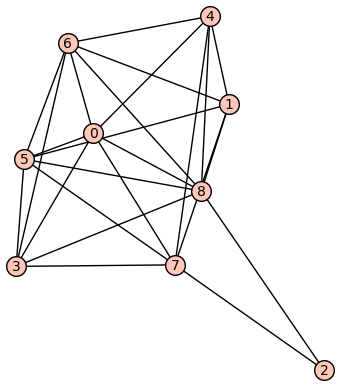

Counterexample graph in graph6 format: LQa^fRP|FW?ic`


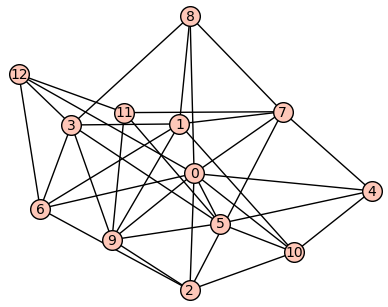

Counterexample graph in graph6 format: H?bvVpy


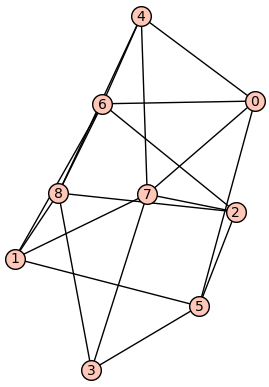


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 1
  n=4: 4 / 1
  n=5: 11 / 0
  n=6: 43 / 0
  n=7: 266 / 0
  n=8: 3042 / 0
  n=9: 69645 / 0
  n=10: 1072 / 0
  n=11: 1049 / 0
  n=12: 952 / 0
  n=13: 1062 / 0
  n=14: 1002 / 0
  n=15: 1015 / 0
  n=16: 1004 / 0
  n=17: 859 / 0
  n=18: 1126 / 0
  n=19: 1078 / 0
  n=20: 979 / 0
  n=21: 1011 / 0
  n=22: 1065 / 0
  n=23: 1144 / 0
  n=24: 1000 / 0
  n=25: 1183 / 0
  n=26: 961 / 0
  n=27: 1035 / 0
  n=28: 893 / 0
  n=29: 971 / 0
  n=30: 980 / 0

Sufficiency test for Bipartite
Tested connected graphs with up to 8 vertices.
Found 250 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: G?`DE_


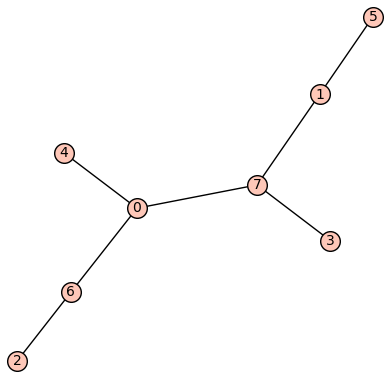

Counterexample graph in graph6 format: F?BFo


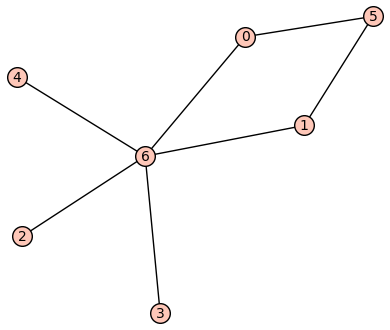

Counterexample graph in graph6 format: DQo


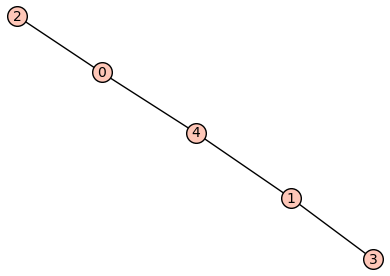


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 1 / 1
  n=4: 3 / 1
  n=5: 5 / 0
  n=6: 17 / 0
  n=7: 44 / 0
  n=8: 182 / 0

Property: Chordal
----------------------------------------------------------------------
Necessity test for Chordal
Tested 94456 graphs with alpha_od = 1.
Found 93177 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: H?zne~z


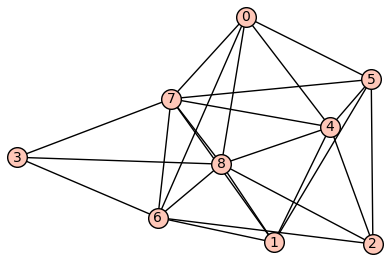

Counterexample graph in graph6 format: HCRTv^^


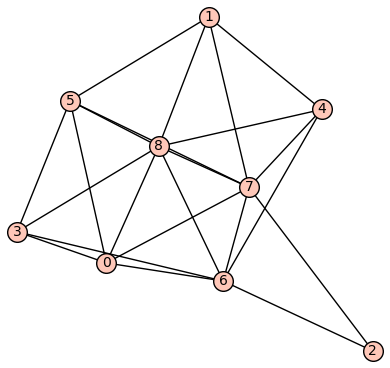

Counterexample graph in graph6 format: HCvdn]~


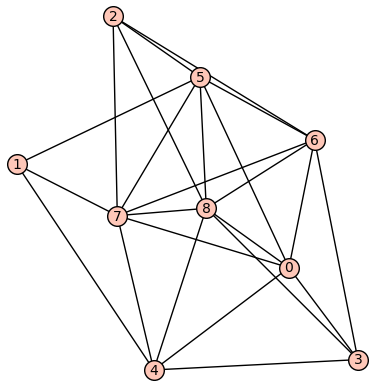


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 4 / 3
  n=5: 11 / 7
  n=6: 43 / 17
  n=7: 266 / 53
  n=8: 3042 / 200
  n=9: 69645 / 993
  n=10: 1072 / 2
  n=11: 1049 / 0
  n=12: 952 / 0
  n=13: 1062 / 0
  n=14: 1002 / 0
  n=15: 1015 / 0
  n=16: 1004 / 0
  n=17: 859 / 0
  n=18: 1126 / 0
  n=19: 1078 / 0
  n=20: 979 / 0
  n=21: 1011 / 0
  n=22: 1065 / 0
  n=23: 1144 / 0
  n=24: 1000 / 0
  n=25: 1183 / 0
  n=26: 961 / 0
  n=27: 1035 / 0
  n=28: 893 / 0
  n=29: 971 / 0
  n=30: 980 / 0

Sufficiency test for Chordal
Tested connected graphs with up to 8 vertices.
Found 1684 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: GCQSnO


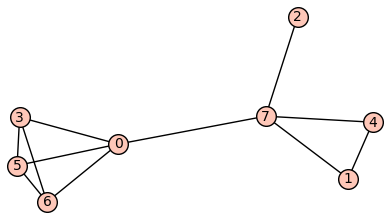

Counterexample graph in graph6 format: FCdew


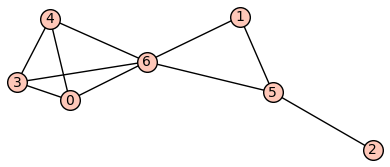

Counterexample graph in graph6 format: F??Fw


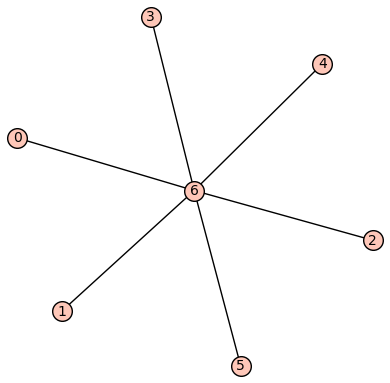


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 5 / 3
  n=5: 15 / 7
  n=6: 58 / 17
  n=7: 272 / 53
  n=8: 1614 / 200

Property: Line graph
----------------------------------------------------------------------
Necessity test for Line graph
Tested 94456 graphs with alpha_od = 1.
Found 94298 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: TBFmeodaCEiOoA`?KPcCarkogfPS{CoBE_yL


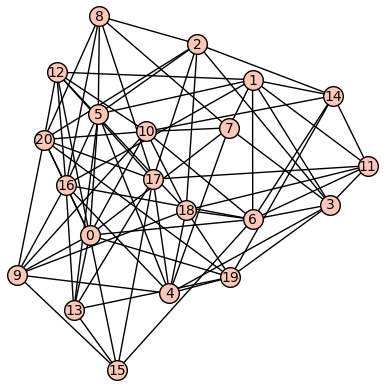

Counterexample graph in graph6 format: HCZT|z^


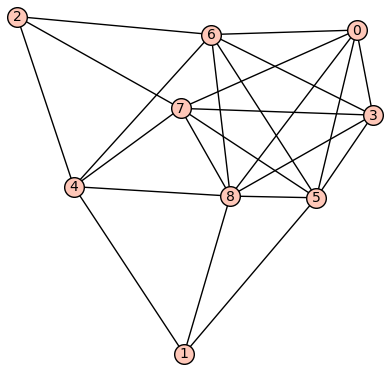

Counterexample graph in graph6 format: H?rfm~|


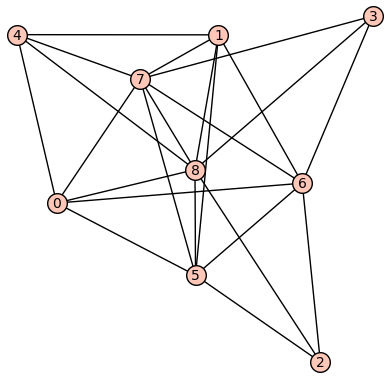


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 4 / 4
  n=5: 11 / 8
  n=6: 43 / 13
  n=7: 266 / 22
  n=8: 3042 / 38
  n=9: 69645 / 69
  n=10: 1072 / 0
  n=11: 1049 / 0
  n=12: 952 / 0
  n=13: 1062 / 0
  n=14: 1002 / 0
  n=15: 1015 / 0
  n=16: 1004 / 0
  n=17: 859 / 0
  n=18: 1126 / 0
  n=19: 1078 / 0
  n=20: 979 / 0
  n=21: 1011 / 0
  n=22: 1065 / 0
  n=23: 1144 / 0
  n=24: 1000 / 0
  n=25: 1183 / 0
  n=26: 961 / 0
  n=27: 1035 / 0
  n=28: 893 / 0
  n=29: 971 / 0
  n=30: 980 / 0

Sufficiency test for Line graph
Tested connected graphs with up to 8 vertices.
Found 268 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: FCdeG


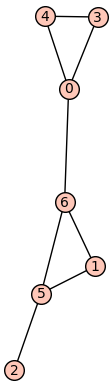

Counterexample graph in graph6 format: EEio


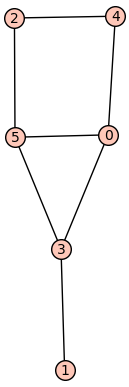

Counterexample graph in graph6 format: GCQbTg


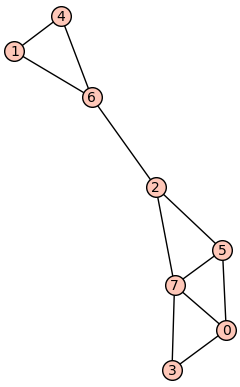


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 5 / 4
  n=5: 12 / 8
  n=6: 30 / 13
  n=7: 79 / 22
  n=8: 227 / 38

Property: Strongly regular
----------------------------------------------------------------------
Necessity test for Strongly regular
Tested 94456 graphs with alpha_od = 1.
Found 94451 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: [PeM\k\gEaNKoOjFQH~qsxyocB\}ro{sfAW|vtv[]VcEFFO?lhMEfkibOKFAO{Zi


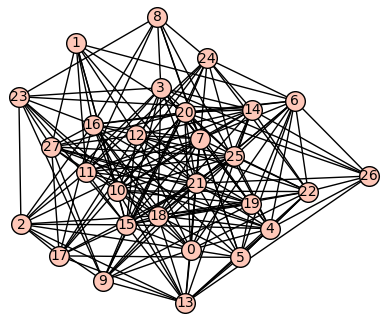

Counterexample graph in graph6 format: HEhvTnt


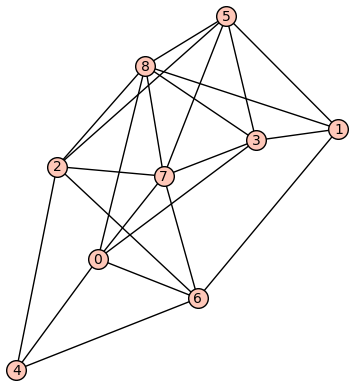

Counterexample graph in graph6 format: H?bvVpy


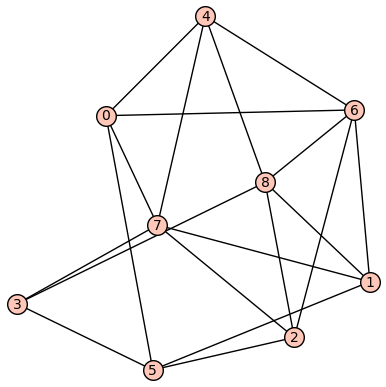


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 0
  n=2: 1 / 0
  n=3: 2 / 0
  n=4: 4 / 1
  n=5: 11 / 1
  n=6: 43 / 1
  n=7: 266 / 0
  n=8: 3042 / 1
  n=9: 69645 / 1
  n=10: 1072 / 0
  n=11: 1049 / 0
  n=12: 952 / 0
  n=13: 1062 / 0
  n=14: 1002 / 0
  n=15: 1015 / 0
  n=16: 1004 / 0
  n=17: 859 / 0
  n=18: 1126 / 0
  n=19: 1078 / 0
  n=20: 979 / 0
  n=21: 1011 / 0
  n=22: 1065 / 0
  n=23: 1144 / 0
  n=24: 1000 / 0
  n=25: 1183 / 0
  n=26: 961 / 0
  n=27: 1035 / 0
  n=28: 893 / 0
  n=29: 971 / 0
  n=30: 980 / 0

Sufficiency test for Strongly regular
Tested connected graphs with up to 8 vertices.
Found 2 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: EFz_


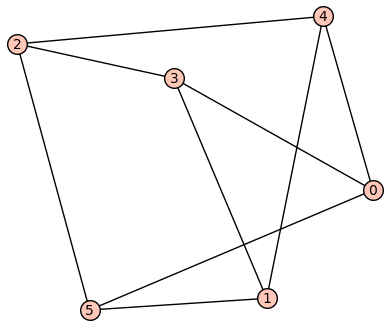

Counterexample graph in graph6 format: G?~vf_


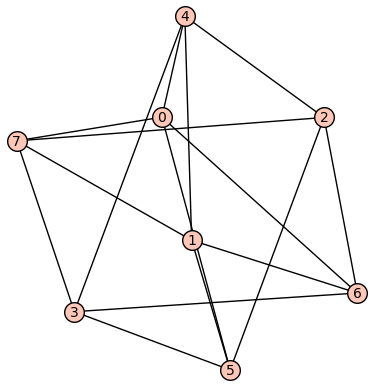


Stats (graphs with property / have alpha_od=1):
  n=1: 0 / 0
  n=2: 0 / 0
  n=3: 0 / 0
  n=4: 1 / 1
  n=5: 1 / 1
  n=6: 2 / 1
  n=7: 0 / 0
  n=8: 2 / 1

Property: Planar
----------------------------------------------------------------------
Necessity test for Planar
Tested 94456 graphs with alpha_od = 1.
Found 92157 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: Tu_TCZa_DAdcGcO_q`[bBjSCNEEg}LODBXDS


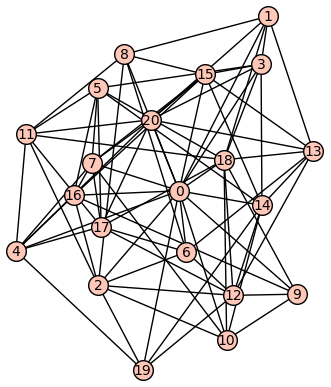

Counterexample graph in graph6 format: HCxv^hz


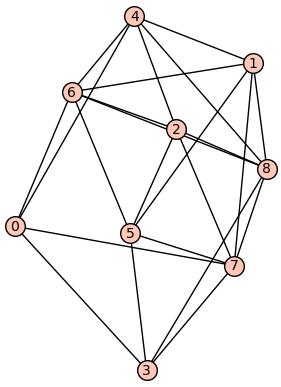

Counterexample graph in graph6 format: HEhvFv]


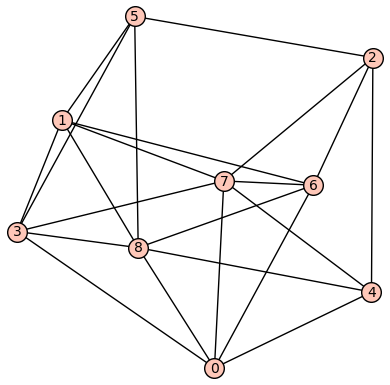


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 4 / 4
  n=5: 11 / 10
  n=6: 43 / 34
  n=7: 266 / 131
  n=8: 3042 / 499
  n=9: 69645 / 1613
  n=10: 1072 / 4
  n=11: 1049 / 0
  n=12: 952 / 0
  n=13: 1062 / 0
  n=14: 1002 / 0
  n=15: 1015 / 0
  n=16: 1004 / 0
  n=17: 859 / 0
  n=18: 1126 / 0
  n=19: 1078 / 0
  n=20: 979 / 0
  n=21: 1011 / 0
  n=22: 1065 / 0
  n=23: 1144 / 0
  n=24: 1000 / 0
  n=25: 1183 / 0
  n=26: 961 / 0
  n=27: 1035 / 0
  n=28: 893 / 0
  n=29: 971 / 0
  n=30: 980 / 0

Sufficiency test for Planar
Tested connected graphs with up to 8 vertices.
Found 6067 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: GCpdrw


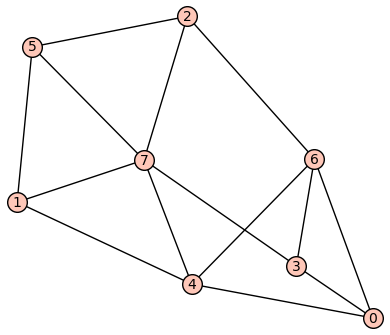

Counterexample graph in graph6 format: G?BDnO


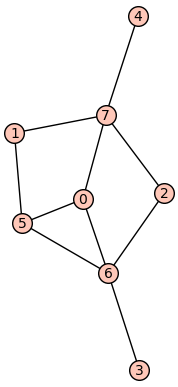

Counterexample graph in graph6 format: F?qv_


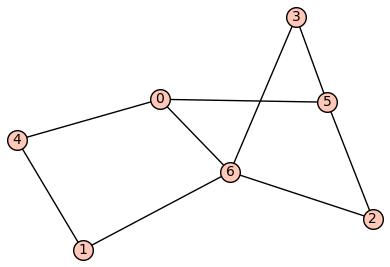


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 6 / 4
  n=5: 20 / 10
  n=6: 99 / 34
  n=7: 646 / 131
  n=8: 5974 / 499

Property: Edge connectivity at least 2
----------------------------------------------------------------------
Necessity test for Edge connectivity at least 2
Tested 94456 graphs with alpha_od = 1.
Found 331 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: HCe[}~~


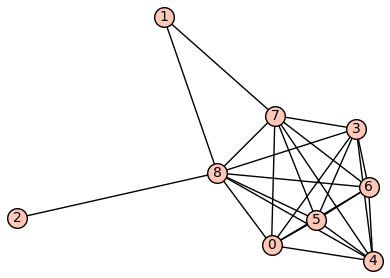

Counterexample graph in graph6 format: H?`e^Z~


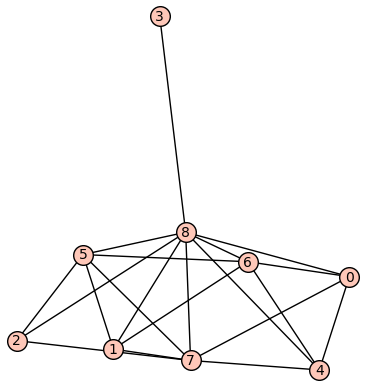

Counterexample graph in graph6 format: H?rNVJ~


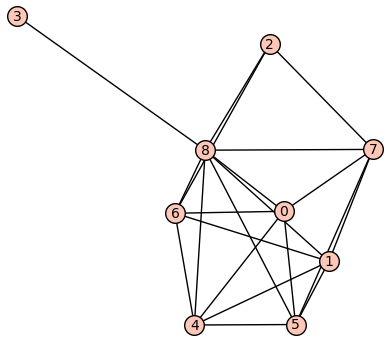


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 0
  n=2: 1 / 0
  n=3: 2 / 1
  n=4: 4 / 3
  n=5: 11 / 9
  n=6: 43 / 39
  n=7: 266 / 255
  n=8: 3042 / 2999
  n=9: 69645 / 69379
  n=10: 1072 / 1072
  n=11: 1049 / 1048
  n=12: 952 / 952
  n=13: 1062 / 1062
  n=14: 1002 / 1002
  n=15: 1015 / 1015
  n=16: 1004 / 1004
  n=17: 859 / 859
  n=18: 1126 / 1126
  n=19: 1078 / 1078
  n=20: 979 / 979
  n=21: 1011 / 1011
  n=22: 1065 / 1065
  n=23: 1144 / 1144
  n=24: 1000 / 1000
  n=25: 1183 / 1183
  n=26: 961 / 961
  n=27: 1035 / 1035
  n=28: 893 / 893
  n=29: 971 / 971
  n=30: 980 / 980

Sufficiency test for Edge connectivity at least 2
Tested connected graphs with up to 8 vertices.
Found 4674 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: G?bmvo


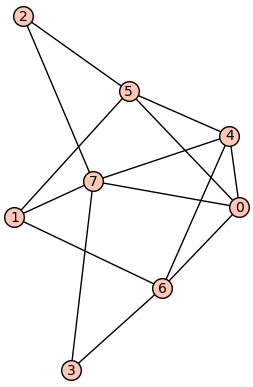

Counterexample graph in graph6 format: FErvg


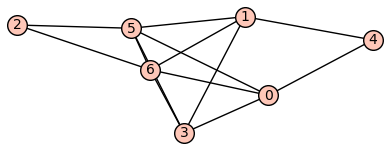

Counterexample graph in graph6 format: GCQfn{


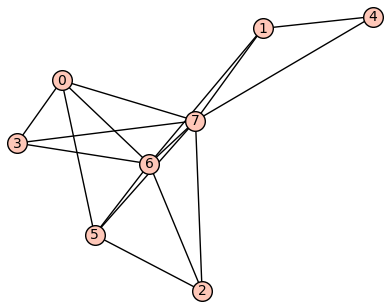


Stats (graphs with property / have alpha_od=1):
  n=1: 0 / 0
  n=2: 0 / 0
  n=3: 1 / 1
  n=4: 3 / 3
  n=5: 11 / 9
  n=6: 60 / 39
  n=7: 502 / 255
  n=8: 7403 / 2999

Property: Vertex connectivity at least 2
----------------------------------------------------------------------
Necessity test for Vertex connectivity at least 2
Tested 94456 graphs with alpha_od = 1.
Found 434 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: H?Benb~


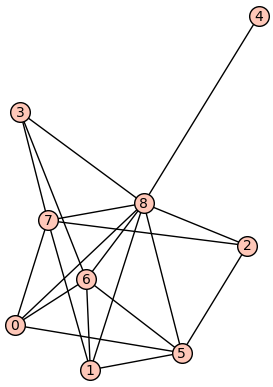

Counterexample graph in graph6 format: HCRUuv~


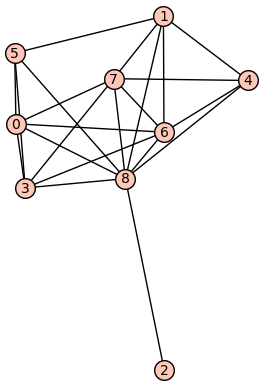

Counterexample graph in graph6 format: FTm~w


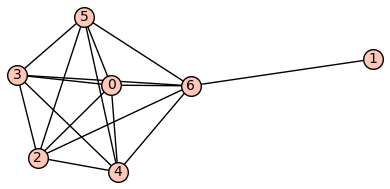


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 0
  n=2: 1 / 0
  n=3: 2 / 1
  n=4: 4 / 3
  n=5: 11 / 8
  n=6: 43 / 37
  n=7: 266 / 248
  n=8: 3042 / 2980
  n=9: 69645 / 69304
  n=10: 1072 / 1072
  n=11: 1049 / 0
  n=12: 952 / 0
  n=13: 1062 / 0
  n=14: 1002 / 0
  n=15: 1015 / 0
  n=16: 1004 / 0
  n=17: 859 / 0
  n=18: 1126 / 0
  n=19: 1078 / 0
  n=20: 979 / 0
  n=21: 1011 / 0
  n=22: 1065 / 0
  n=23: 1144 / 0
  n=24: 1000 / 0
  n=25: 1183 / 0
  n=26: 961 / 0
  n=27: 1035 / 0
  n=28: 893 / 0
  n=29: 971 / 0
  n=30: 980 / 0

Sufficiency test for Vertex connectivity at least 2
Tested connected graphs with up to 8 vertices.
Found 4384 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: G?qfb{


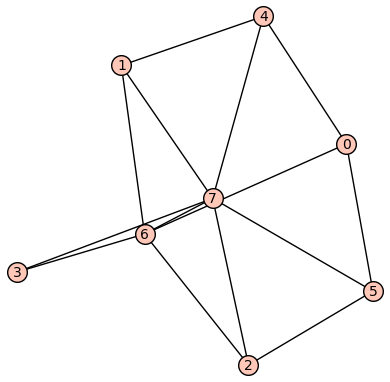

Counterexample graph in graph6 format: FEzeW


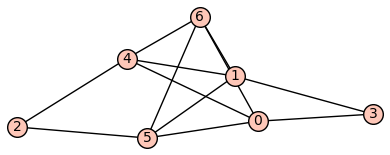

Counterexample graph in graph6 format: GCRbjw


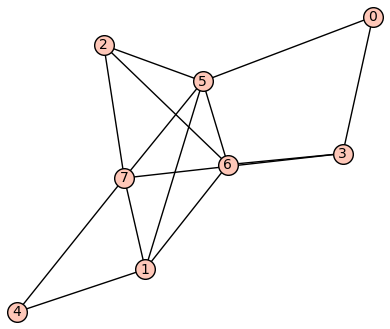


Stats (graphs with property / have alpha_od=1):
  n=1: 0 / 0
  n=2: 0 / 0
  n=3: 1 / 1
  n=4: 3 / 3
  n=5: 10 / 8
  n=6: 56 / 37
  n=7: 468 / 248
  n=8: 7123 / 2980

Property: Complement connected
----------------------------------------------------------------------
Necessity test for Complement connected
Tested 94456 graphs with alpha_od = 1.
Found 9220 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: HCQdnj~


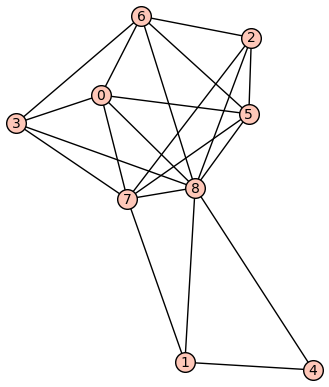

Counterexample graph in graph6 format: H?ovfr~


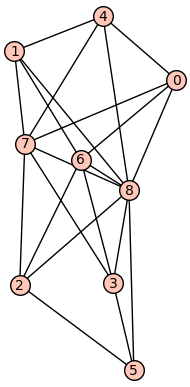

Counterexample graph in graph6 format: H?qmvb~


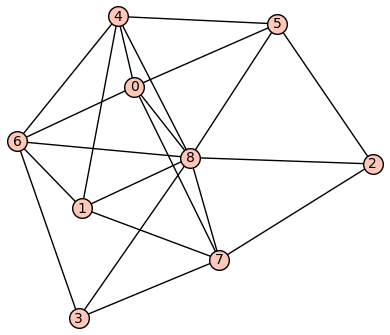


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 0
  n=3: 2 / 0
  n=4: 4 / 0
  n=5: 11 / 2
  n=6: 43 / 15
  n=7: 266 / 150
  n=8: 3042 / 2310
  n=9: 69645 / 61360
  n=10: 1072 / 1057
  n=11: 1049 / 1035
  n=12: 952 / 947
  n=13: 1062 / 1057
  n=14: 1002 / 998
  n=15: 1015 / 1015
  n=16: 1004 / 1004
  n=17: 859 / 859
  n=18: 1126 / 1126
  n=19: 1078 / 1078
  n=20: 979 / 979
  n=21: 1011 / 1011
  n=22: 1065 / 1065
  n=23: 1144 / 1144
  n=24: 1000 / 1000
  n=25: 1183 / 1183
  n=26: 961 / 961
  n=27: 1035 / 1035
  n=28: 893 / 893
  n=29: 971 / 971
  n=30: 980 / 980

Sufficiency test for Complement connected
Tested connected graphs with up to 8 vertices.
Found 8150 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: GCRcpw


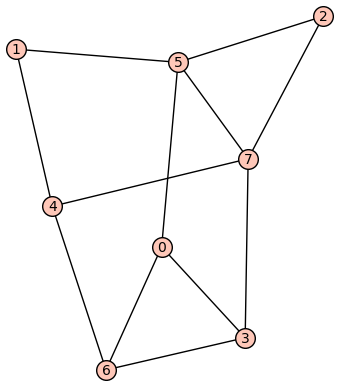

Counterexample graph in graph6 format: G?BfFw


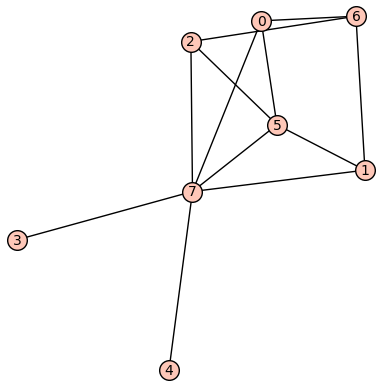

Counterexample graph in graph6 format: F?q~g


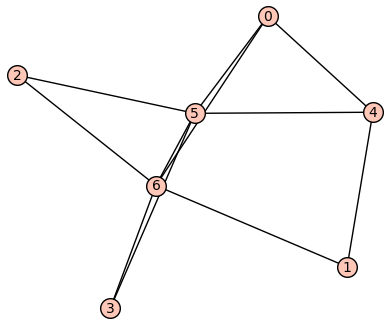


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 0 / 0
  n=3: 0 / 0
  n=4: 1 / 0
  n=5: 8 / 2
  n=6: 68 / 15
  n=7: 662 / 150
  n=8: 9888 / 2310

Property: Self complementary
----------------------------------------------------------------------
Necessity test for Self complementary
Tested 94456 graphs with alpha_od = 1.
Found 94435 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: H?`c~rm


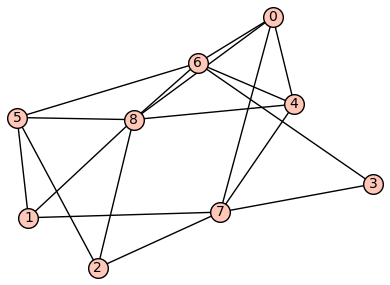

Counterexample graph in graph6 format: HEhrvNf


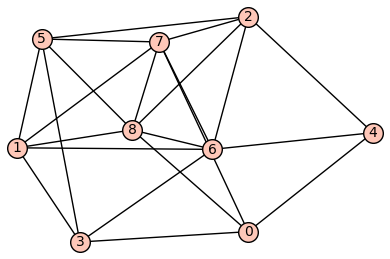

Counterexample graph in graph6 format: MUtedIVhF_EGd@uI_


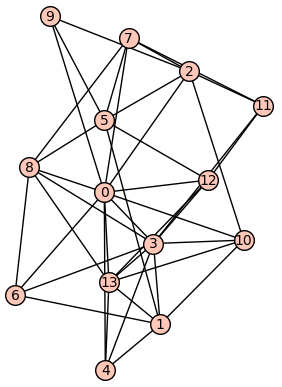


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 0
  n=3: 2 / 0
  n=4: 4 / 0
  n=5: 11 / 1
  n=6: 43 / 0
  n=7: 266 / 0
  n=8: 3042 / 2
  n=9: 69645 / 17
  n=10: 1072 / 0
  n=11: 1049 / 0
  n=12: 952 / 0
  n=13: 1062 / 0
  n=14: 1002 / 0
  n=15: 1015 / 0
  n=16: 1004 / 0
  n=17: 859 / 0
  n=18: 1126 / 0
  n=19: 1078 / 0
  n=20: 979 / 0
  n=21: 1011 / 0
  n=22: 1065 / 0
  n=23: 1144 / 0
  n=24: 1000 / 0
  n=25: 1183 / 0
  n=26: 961 / 0
  n=27: 1035 / 0
  n=28: 893 / 0
  n=29: 971 / 0
  n=30: 980 / 0

Sufficiency test for Self complementary
Tested connected graphs with up to 8 vertices.
Found 10 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: DEk


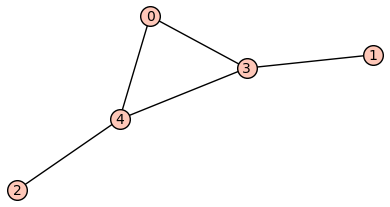

Counterexample graph in graph6 format: CU


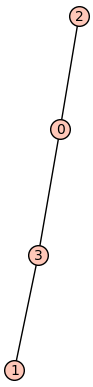

Counterexample graph in graph6 format: G?o|Y{


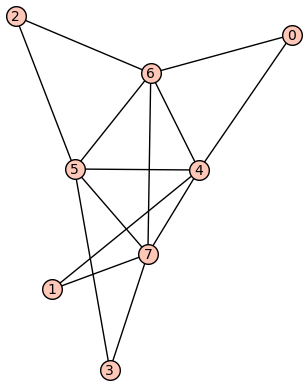


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 0 / 0
  n=3: 0 / 0
  n=4: 1 / 0
  n=5: 2 / 1
  n=6: 0 / 0
  n=7: 0 / 0
  n=8: 10 / 2

Property: alpha(G) <= n/2
----------------------------------------------------------------------
Necessity test for alpha(G) <= n/2
Tested 94456 graphs with alpha_od = 1.
Found 243 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: H?BvVr^


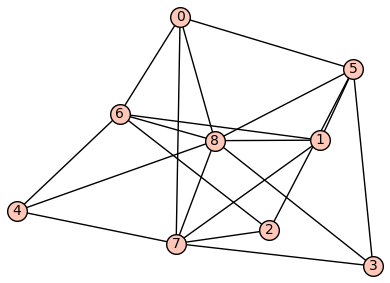

Counterexample graph in graph6 format: H?Bcrxy


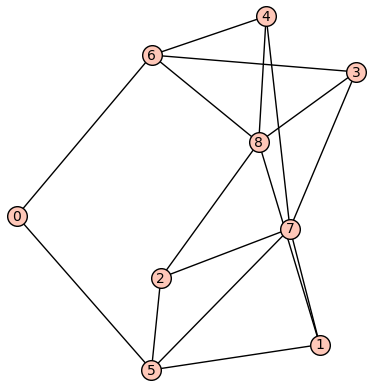

Counterexample graph in graph6 format: H?B@|nz


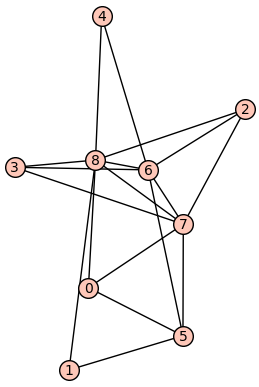


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 0
  n=2: 1 / 1
  n=3: 2 / 1
  n=4: 4 / 4
  n=5: 11 / 10
  n=6: 43 / 43
  n=7: 266 / 258
  n=8: 3042 / 3041
  n=9: 69645 / 69414
  n=10: 1072 / 1072
  n=11: 1049 / 1049
  n=12: 952 / 952
  n=13: 1062 / 1062
  n=14: 1002 / 1002
  n=15: 1015 / 1015
  n=16: 1004 / 1004
  n=17: 859 / 859
  n=18: 1126 / 1126
  n=19: 1078 / 1078
  n=20: 979 / 979
  n=21: 1011 / 1011
  n=22: 1065 / 1065
  n=23: 1144 / 1144
  n=24: 1000 / 1000
  n=25: 1183 / 1183
  n=26: 961 / 961
  n=27: 1035 / 1035
  n=28: 893 / 893
  n=29: 971 / 971
  n=30: 980 / 980

Sufficiency test for alpha(G) <= n/2
Tested connected graphs with up to 8 vertices.
Found 7964 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: GCRTvo


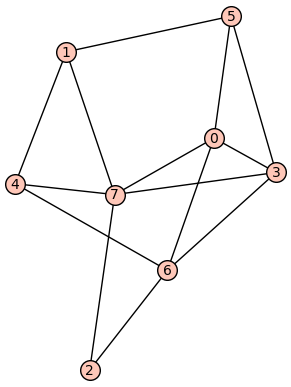

Counterexample graph in graph6 format: G?bFJo


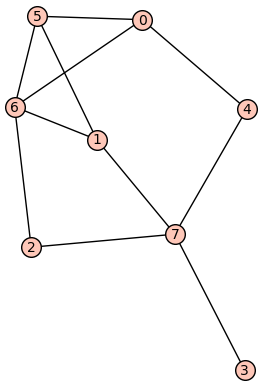

Counterexample graph in graph6 format: FCZbO


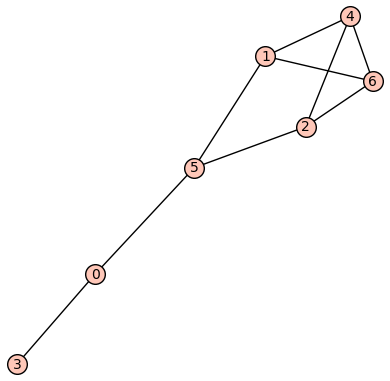


Stats (graphs with property / have alpha_od=1):
  n=1: 0 / 0
  n=2: 1 / 1
  n=3: 1 / 1
  n=4: 5 / 4
  n=5: 12 / 10
  n=6: 98 / 43
  n=7: 628 / 258
  n=8: 10577 / 3041

Property: alpha(G) = 1
----------------------------------------------------------------------
Necessity test for alpha(G) = 1
Tested 94456 graphs with alpha_od = 1.
Found 94447 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: HQjndzl


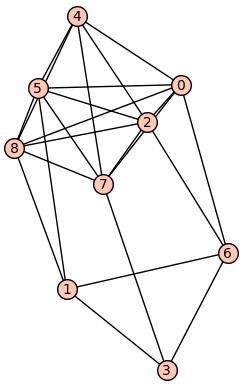

Counterexample graph in graph6 format: HCZJzzu


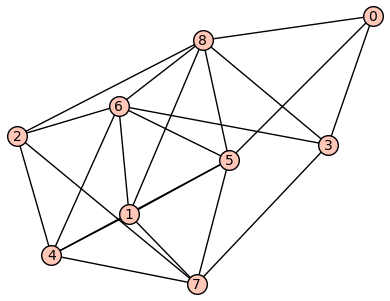

Counterexample graph in graph6 format: HTnvvnv


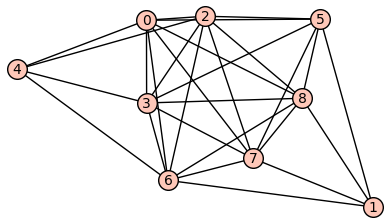


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 1
  n=4: 4 / 1
  n=5: 11 / 1
  n=6: 43 / 1
  n=7: 266 / 1
  n=8: 3042 / 1
  n=9: 69645 / 1
  n=10: 1072 / 0
  n=11: 1049 / 0
  n=12: 952 / 0
  n=13: 1062 / 0
  n=14: 1002 / 0
  n=15: 1015 / 0
  n=16: 1004 / 0
  n=17: 859 / 0
  n=18: 1126 / 0
  n=19: 1078 / 0
  n=20: 979 / 0
  n=21: 1011 / 0
  n=22: 1065 / 0
  n=23: 1144 / 0
  n=24: 1000 / 0
  n=25: 1183 / 0
  n=26: 961 / 0
  n=27: 1035 / 0
  n=28: 893 / 0
  n=29: 971 / 0
  n=30: 980 / 0

Sufficiency test for alpha(G) = 1
Tested connected graphs with up to 8 vertices.
Found 0 counterexamples.
No counterexamples found. The property appears sufficient.

Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 1 / 1
  n=4: 1 / 1
  n=5: 1 / 1
  n=6: 1 / 1
  n=7: 1 / 1
  n=8: 1 / 1

Property: alpha(G^2) == 1
----------------------------------------------------------------------
Necessity test for alpha(G^2) == 1
Tested 94456 graph

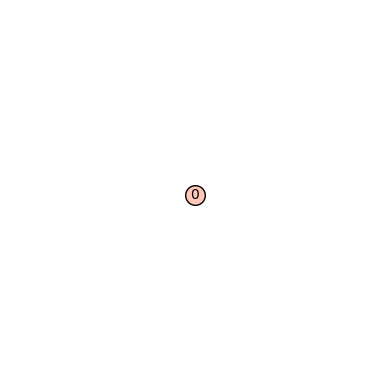


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 0
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 4 / 4
  n=5: 11 / 11
  n=6: 43 / 43
  n=7: 266 / 266
  n=8: 3042 / 3042
  n=9: 69645 / 69645
  n=10: 1072 / 1072
  n=11: 1049 / 1049
  n=12: 952 / 952
  n=13: 1062 / 1062
  n=14: 1002 / 1002
  n=15: 1015 / 1015
  n=16: 1004 / 1004
  n=17: 859 / 859
  n=18: 1126 / 1126
  n=19: 1078 / 1078
  n=20: 979 / 979
  n=21: 1011 / 1011
  n=22: 1065 / 1065
  n=23: 1144 / 1144
  n=24: 1000 / 1000
  n=25: 1183 / 1183
  n=26: 961 / 961
  n=27: 1035 / 1035
  n=28: 893 / 893
  n=29: 971 / 971
  n=30: 980 / 980

Sufficiency test for alpha(G^2) == 1
Tested connected graphs with up to 8 vertices.
Found 1243 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: G?`FF{


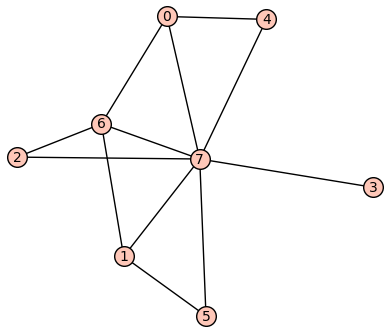

Counterexample graph in graph6 format: F?rvo


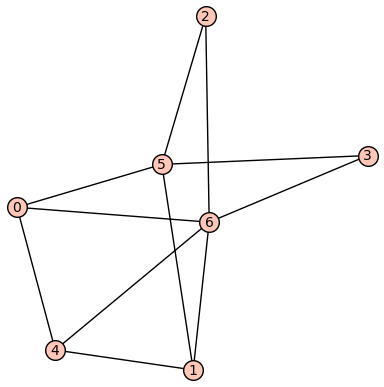

Counterexample graph in graph6 format: G?rdr{


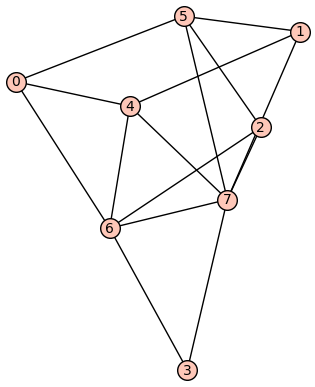


Stats (graphs with property / have alpha_od=1):
  n=1: 0 / 0
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 5 / 4
  n=5: 15 / 11
  n=6: 60 / 43
  n=7: 374 / 266
  n=8: 4155 / 3042

Property: chi_so(G) = n
----------------------------------------------------------------------
Necessity test for chi_so(G) = n
Tested 94456 graphs with alpha_od = 1.
Found 0 counterexamples.
No counterexamples found. The property appears necessary.

Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 4 / 4
  n=5: 11 / 11
  n=6: 43 / 43
  n=7: 266 / 0
  n=8: 3042 / 0
  n=9: 69645 / 0
  n=10: 1072 / 0
  n=11: 1049 / 0
  n=12: 952 / 0
  n=13: 1062 / 0
  n=14: 1002 / 0
  n=15: 1015 / 0
  n=16: 1004 / 0
  n=17: 859 / 0
  n=18: 1126 / 0
  n=19: 1078 / 0
  n=20: 979 / 0
  n=21: 1011 / 0
  n=22: 1065 / 0
  n=23: 1144 / 0
  n=24: 1000 / 0
  n=25: 1183 / 0
  n=26: 961 / 0
  n=27: 1035 / 0
  n=28: 893 / 0
  n=29: 971 / 0
  n=30: 980 / 0

Sufficiency test for chi_so(G) = n
Tested connect

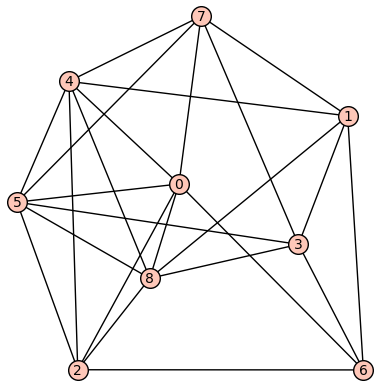

Counterexample graph in graph6 format: H?`c~Zx


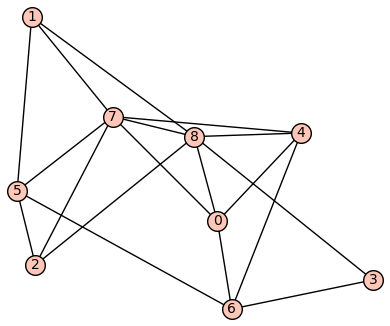

Counterexample graph in graph6 format: HCZUvn}


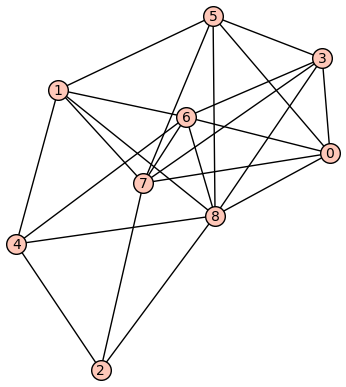


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 4 / 3
  n=5: 11 / 7
  n=6: 43 / 21
  n=7: 266 / 84
  n=8: 3042 / 555
  n=9: 69645 / 5786
  n=10: 1072 / 194
  n=11: 1049 / 0
  n=12: 952 / 0
  n=13: 1062 / 0
  n=14: 1002 / 0
  n=15: 1015 / 0
  n=16: 1004 / 0
  n=17: 859 / 0
  n=18: 1126 / 0
  n=19: 1078 / 0
  n=20: 979 / 0
  n=21: 1011 / 0
  n=22: 1065 / 0
  n=23: 1144 / 0
  n=24: 1000 / 0
  n=25: 1183 / 0
  n=26: 961 / 0
  n=27: 1035 / 0
  n=28: 893 / 0
  n=29: 971 / 0
  n=30: 980 / 0

Sufficiency test for chi(G) <= 3
Tested connected graphs with up to 8 vertices.
Found 5170 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: G?Beuo


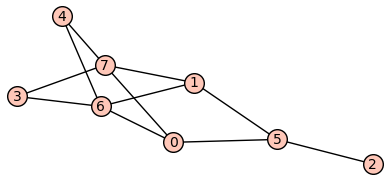

Counterexample graph in graph6 format: F?qtw


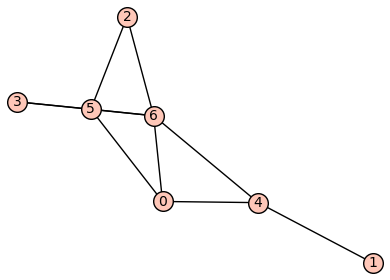

Counterexample graph in graph6 format: G?`rnw


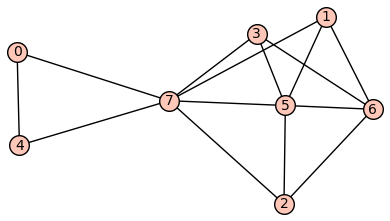


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 5 / 3
  n=5: 17 / 7
  n=6: 81 / 21
  n=7: 519 / 84
  n=8: 5218 / 555

Property: Density at least 0.6
----------------------------------------------------------------------
Necessity test for Density at least 0.6
Tested 94456 graphs with alpha_od = 1.
Found 63092 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: HCQUdzv


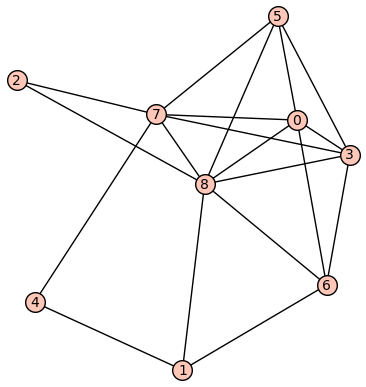

Counterexample graph in graph6 format: HCZM^`~


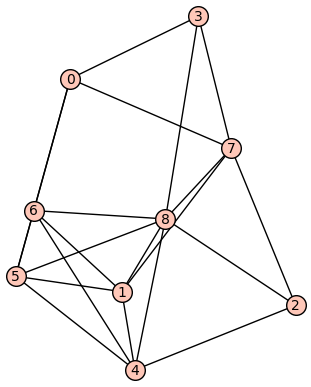

Counterexample graph in graph6 format: KUWTElIZBgXc


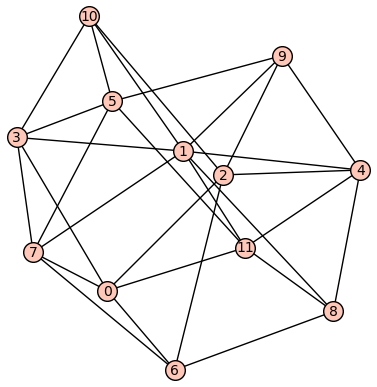


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 4 / 4
  n=5: 11 / 10
  n=6: 43 / 37
  n=7: 266 / 174
  n=8: 3042 / 1761
  n=9: 69645 / 28920
  n=10: 1072 / 67
  n=11: 1049 / 58
  n=12: 952 / 31
  n=13: 1062 / 30
  n=14: 1002 / 15
  n=15: 1015 / 9
  n=16: 1004 / 12
  n=17: 859 / 7
  n=18: 1126 / 9
  n=19: 1078 / 10
  n=20: 979 / 10
  n=21: 1011 / 9
  n=22: 1065 / 12
  n=23: 1144 / 13
  n=24: 1000 / 13
  n=25: 1183 / 22
  n=26: 961 / 22
  n=27: 1035 / 25
  n=28: 893 / 22
  n=29: 971 / 26
  n=30: 980 / 32

Sufficiency test for Density at least 0.6
Tested connected graphs with up to 8 vertices.
Found 784 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: GEjvc{


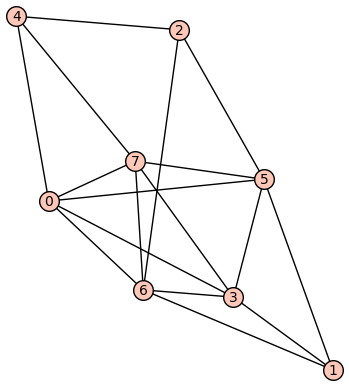

Counterexample graph in graph6 format: G?rL~{


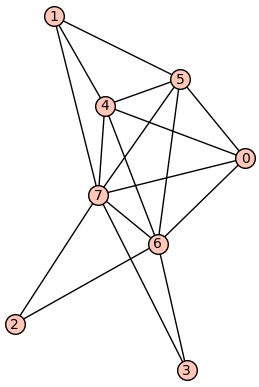

Counterexample graph in graph6 format: F?~~w


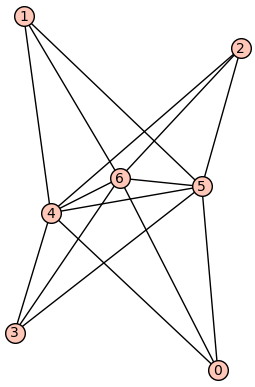


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 1 / 1
  n=3: 2 / 2
  n=4: 4 / 4
  n=5: 13 / 10
  n=6: 52 / 37
  n=7: 239 / 174
  n=8: 2462 / 1761

Property: Density between 0.4 and 0.6
----------------------------------------------------------------------
Necessity test for Density between 0.4 and 0.6
Tested 94456 graphs with alpha_od = 1.
Found 37632 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: HQjvvr^


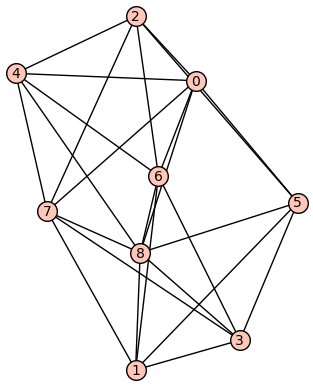

Counterexample graph in graph6 format: UOdCBFwWKg\`DSOpO`aG?~WcFaiCweeRBI?WgCw_


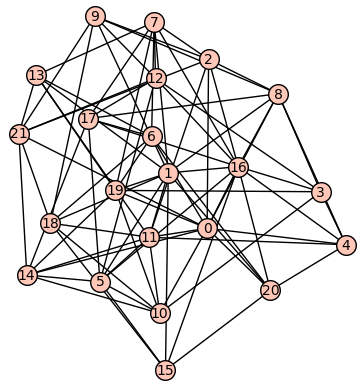

Counterexample graph in graph6 format: HQjfN^~


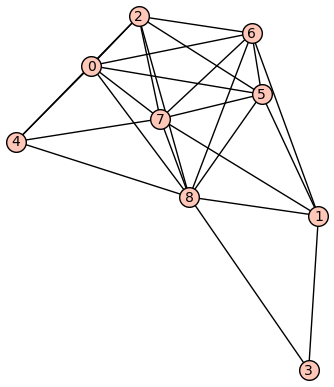


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 0
  n=3: 2 / 0
  n=4: 4 / 0
  n=5: 11 / 4
  n=6: 43 / 17
  n=7: 266 / 92
  n=8: 3042 / 1281
  n=9: 69645 / 40722
  n=10: 1072 / 1032
  n=11: 1049 / 1014
  n=12: 952 / 918
  n=13: 1062 / 1022
  n=14: 1002 / 970
  n=15: 1015 / 977
  n=16: 1004 / 955
  n=17: 859 / 684
  n=18: 1126 / 690
  n=19: 1078 / 684
  n=20: 979 / 550
  n=21: 1011 / 540
  n=22: 1065 / 527
  n=23: 1144 / 548
  n=24: 1000 / 556
  n=25: 1183 / 570
  n=26: 961 / 318
  n=27: 1035 / 554
  n=28: 893 / 567
  n=29: 971 / 580
  n=30: 980 / 451

Sufficiency test for Density between 0.4 and 0.6
Tested connected graphs with up to 8 vertices.
Found 6205 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: GCZfN[


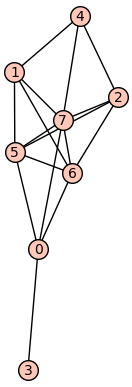

Counterexample graph in graph6 format: G?`an[


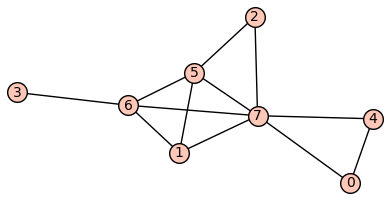

Counterexample graph in graph6 format: FCRfG


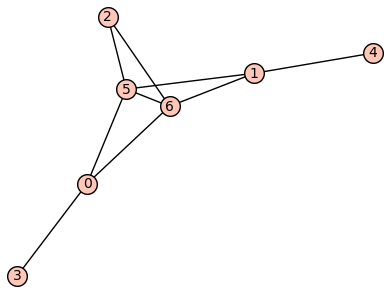


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 0 / 0
  n=3: 0 / 0
  n=4: 2 / 0
  n=5: 13 / 4
  n=6: 74 / 17
  n=7: 503 / 92
  n=8: 7007 / 1281

Property: Hamiltonian
----------------------------------------------------------------------
Necessity test for Hamiltonian
Tested 94456 graphs with alpha_od = 1.
Found 961 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: H?qfVZ~


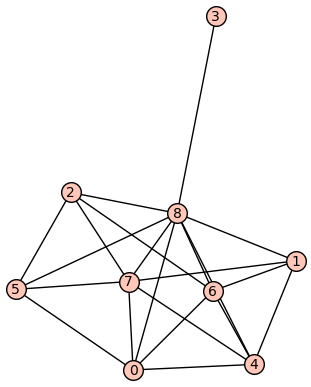

Counterexample graph in graph6 format: G?quZw


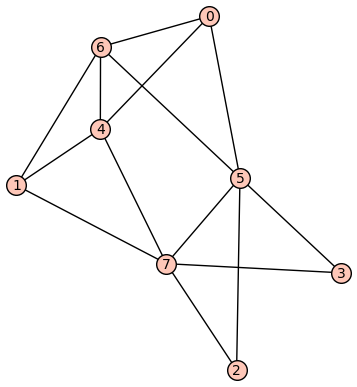

Counterexample graph in graph6 format: H?rfF^~


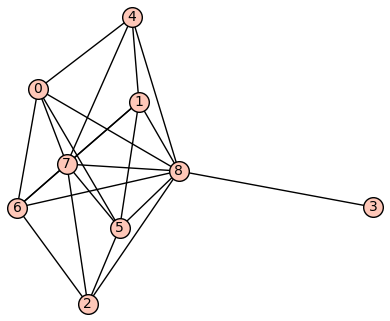


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 0
  n=2: 1 / 0
  n=3: 2 / 1
  n=4: 4 / 3
  n=5: 11 / 8
  n=6: 43 / 35
  n=7: 266 / 238
  n=8: 3042 / 2925
  n=9: 69645 / 68849
  n=10: 1072 / 1068
  n=11: 1049 / 1048
  n=12: 952 / 952
  n=13: 1062 / 1062
  n=14: 1002 / 1002
  n=15: 1015 / 1015
  n=16: 1004 / 1004
  n=17: 859 / 859
  n=18: 1126 / 1126
  n=19: 1078 / 1078
  n=20: 979 / 979
  n=21: 1011 / 1011
  n=22: 1065 / 1065
  n=23: 1144 / 1144
  n=24: 1000 / 1000
  n=25: 1183 / 1183
  n=26: 961 / 961
  n=27: 1035 / 1035
  n=28: 893 / 893
  n=29: 971 / 971
  n=30: 980 / 980

Sufficiency test for Hamiltonian
Tested connected graphs with up to 8 vertices.
Found 3429 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: GCZL]{


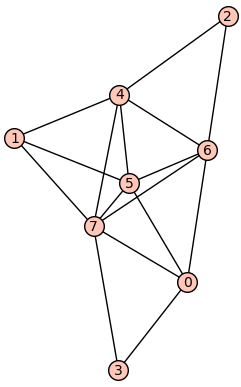

Counterexample graph in graph6 format: G?ren{


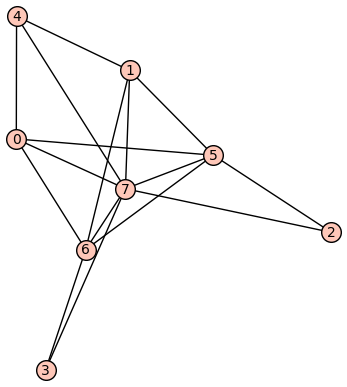

Counterexample graph in graph6 format: FEhbo


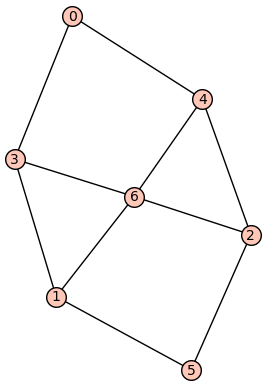


Stats (graphs with property / have alpha_od=1):
  n=1: 0 / 0
  n=2: 0 / 0
  n=3: 1 / 1
  n=4: 3 / 3
  n=5: 8 / 8
  n=6: 48 / 35
  n=7: 383 / 238
  n=8: 6196 / 2925

Property: Eulerian
----------------------------------------------------------------------
Necessity test for Eulerian
Tested 94456 graphs with alpha_od = 1.
Found 93853 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: H?rfe}~


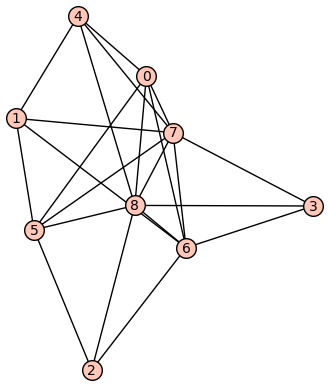

Counterexample graph in graph6 format: KHS]^rCdZSiD


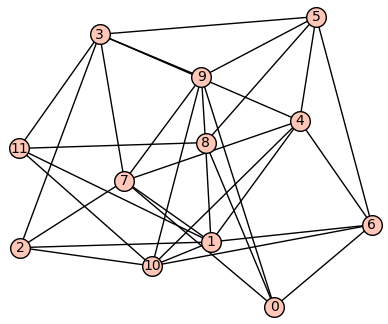

Counterexample graph in graph6 format: H?`uTvl


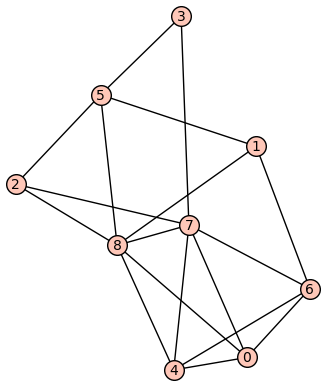


Stats (graphs with alpha_od=1 / satisfy property):
  n=1: 1 / 1
  n=2: 1 / 0
  n=3: 2 / 1
  n=4: 4 / 1
  n=5: 11 / 3
  n=6: 43 / 4
  n=7: 266 / 13
  n=8: 3042 / 60
  n=9: 69645 / 509
  n=10: 1072 / 7
  n=11: 1049 / 2
  n=12: 952 / 2
  n=13: 1062 / 0
  n=14: 1002 / 0
  n=15: 1015 / 0
  n=16: 1004 / 0
  n=17: 859 / 0
  n=18: 1126 / 0
  n=19: 1078 / 0
  n=20: 979 / 0
  n=21: 1011 / 0
  n=22: 1065 / 0
  n=23: 1144 / 0
  n=24: 1000 / 0
  n=25: 1183 / 0
  n=26: 961 / 0
  n=27: 1035 / 0
  n=28: 893 / 0
  n=29: 971 / 0
  n=30: 980 / 0

Sufficiency test for Eulerian
Tested connected graphs with up to 8 vertices.
Found 153 counterexamples.
Showing 3 random counterexamples:
Counterexample graph in graph6 format: FQzUW


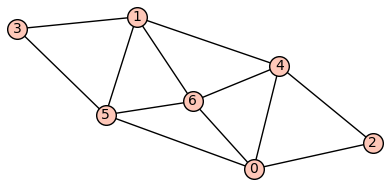

Counterexample graph in graph6 format: F?`vw


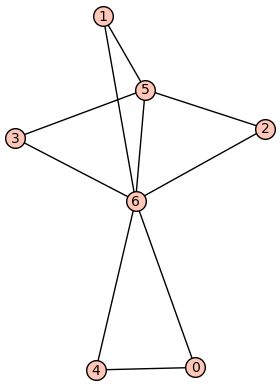

Counterexample graph in graph6 format: G?ouXw


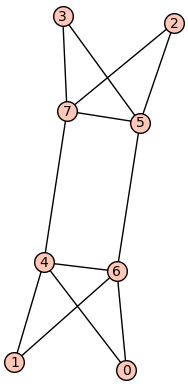


Stats (graphs with property / have alpha_od=1):
  n=1: 1 / 1
  n=2: 0 / 0
  n=3: 1 / 1
  n=4: 1 / 1
  n=5: 4 / 3
  n=6: 8 / 4
  n=7: 37 / 13
  n=8: 184 / 60



In [ ]:
run_all_tests()